In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, kruskal
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

# Set plotting style
plt.style.use("default")
sns.set_theme()

## Load Data

In [21]:
df = pd.read_csv("data/NYC_Inspection_data.csv")

## Basic info & missingness

In [22]:
print("Raw shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nPreview:")
print(df.head())

print("\nData types:")
print(df.dtypes)

print("\nMissing value ratio per column:")
print(df.isna().mean().sort_values(ascending=False))

Raw shape: (103426, 26)

Columns:
 ['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE', 'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE', 'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE', 'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude', 'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL', 'NTA']

Preview:
      CAMIS                   DBA           BORO BUILDING             STREET  \
0  41647571         PEKING GARDEN      Manhattan     3163           BROADWAY   
1  50128737           BAO BY KAYA      Manhattan      570   LEXINGTON AVENUE   
2  40510804         WOODROW DINER  Staten Island      655   ROSSVILLE AVENUE   
3  50077566        JANE FAST FOOD         Queens     8622           BROADWAY   
4  50110452  GREENHOUSE CAFE RBNY         Queens    10810  ROCKAWAY BEACH DR   

   ZIPCODE       PHONE CUISINE DESCRIPTION INSPECTION DATE  \
0    10027  2128653600             Chinese        2/1/2022   
1   

## Restaurant History Features - Pre-Filtering

In [23]:
# Restaurant History Features - Phase 1
# These features use ONLY past inspections to avoid data leakage
# CRITICAL: Must be created BEFORE train/test split AND before filtering to A/B/C grades
# This ensures prev_grade can reference ALL previous inspections, not just A/B/C ones

# Step 1: Ensure INSPECTION DATE is datetime BEFORE any operations
# This must happen FIRST, before sorting or grouping
if not pd.api.types.is_datetime64_any_dtype(df["INSPECTION DATE"]):
    print("Converting INSPECTION DATE to datetime...")
    df["INSPECTION DATE"] = pd.to_datetime(df["INSPECTION DATE"], errors="coerce")

# Step 2: Sort by restaurant ID and inspection date to ensure chronological order
print("Sorting data by CAMIS and INSPECTION DATE...")
df = df.sort_values(by=["CAMIS", "INSPECTION DATE"]).reset_index(drop=True)
print(f"Data sorted. Shape: {df.shape}")

# Step 3: Create restaurant history features using groupby
print("\nCreating restaurant history features...")

# Group by restaurant ID to compute features within each restaurant's history
# NOTE: INSPECTION DATE is now guaranteed to be datetime
grouped = df.groupby("CAMIS")

# 1. Number of prior inspections
df["num_prior_inspections"] = grouped.cumcount()  # Counts from 0, so this is number of PRIOR inspections
print(f"  ✓ Created: num_prior_inspections")
print(f"    Range: {df['num_prior_inspections'].min()} to {df['num_prior_inspections'].max()}")
print(f"    First inspections (0 prior): {(df['num_prior_inspections'] == 0).sum():,} ({((df['num_prior_inspections'] == 0).sum() / len(df) * 100):.1f}%)")

# 2. Previous grade (from immediately preceding inspection)
# Convert GRADE to string first to avoid categorical issues with shift()
df["GRADE_str"] = df["GRADE"].astype(str)
df["prev_grade"] = df.groupby("CAMIS")["GRADE_str"].shift(1)  # Shift by 1 to get previous inspection's grade
# Fill NaN for first inspections with "Unknown"
df["prev_grade"] = df["prev_grade"].fillna("Unknown").astype("category")
# Drop temporary column
df = df.drop(columns=["GRADE_str"])
print(f"  ✓ Created: prev_grade")
print(f"    Value counts:")
print(df["prev_grade"].value_counts())

# 3. Days since last inspection
# INSPECTION DATE is already datetime (converted in Step 1)
df["days_since_last_inspection"] = grouped["INSPECTION DATE"].diff().dt.days
# Fill NaN for first inspections with a large value (or 0, or median - using median of non-null values)
median_days = df["days_since_last_inspection"].median()
# If all values are NaN (shouldn't happen), use 0 as default
if pd.isna(median_days):
    median_days = 0
df["days_since_last_inspection"] = df["days_since_last_inspection"].fillna(median_days)
print(f"  ✓ Created: days_since_last_inspection")
print(f"    Range: {df['days_since_last_inspection'].min():.0f} to {df['days_since_last_inspection'].max():.0f} days")
print(f"    Median: {df['days_since_last_inspection'].median():.0f} days")
print(f"    Mean: {df['days_since_last_inspection'].mean():.0f} days")

print("\n" + "="*70)
print("Phase 1 History Features Summary (BEFORE filtering to A/B/C):")
print("="*70)
print(f"Total rows: {len(df):,}")
print(f"Restaurants with prior inspections: {(df['num_prior_inspections'] > 0).sum():,} ({(df['num_prior_inspections'] > 0).sum() / len(df) * 100:.1f}%)")
print(f"First-time inspections: {(df['num_prior_inspections'] == 0).sum():,} ({(df['num_prior_inspections'] == 0).sum() / len(df) * 100:.1f}%)")
print("="*70)


Converting INSPECTION DATE to datetime...
Sorting data by CAMIS and INSPECTION DATE...
Data sorted. Shape: (103426, 26)

Creating restaurant history features...
  ✓ Created: num_prior_inspections
    Range: 0 to 35
    First inspections (0 prior): 23,577 (22.8%)
  ✓ Created: prev_grade
    Value counts:
prev_grade
A          49948
Unknown    23577
B           8469
Closed      6960
N           5361
C           4675
Z           3880
P            556
Name: count, dtype: int64
  ✓ Created: days_since_last_inspection
    Range: 0 to 1095 days
    Median: 0 days
    Mean: 82 days

Phase 1 History Features Summary (BEFORE filtering to A/B/C):
Total rows: 103,426
Restaurants with prior inspections: 79,849 (77.2%)
First-time inspections: 23,577 (22.8%)


In [24]:
# 1.1 Remove exact duplicate rows
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Dropped {before - after} duplicate rows.")

# 1.2 Convert date columns to datetime
date_cols = ["INSPECTION DATE", "GRADE DATE", "RECORD DATE"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# 1.3 Make ZIPCODE a string (to avoid losing leading zeros, and because it's categorical)
df["ZIPCODE"] = df["ZIPCODE"].astype(str)

# 1.4 Treat some columns as categorical
for col in ["BORO", "CUISINE DESCRIPTION", "INSPECTION TYPE", "GRADE"]:
    df[col] = df[col].astype("category")

Dropped 0 duplicate rows.


## Handling Missing Data

In [25]:
before = df.shape[0]
df = df[~df["SCORE"].isna()]
after = df.shape[0]
print(f"Dropped {before - after} rows with missing SCORE.")

# Focus on grades A, B, C only (simplifies the classification problem)
valid_grades = ["A", "B", "C"]
before = df.shape[0]
df = df[df["GRADE"].isin(valid_grades)]
after = df.shape[0]
print(f"Dropped {before - after} rows with non A/B/C grades or missing grade.")

print("Shape after cleaning:", df.shape)

Dropped 50 rows with missing SCORE.
Dropped 19773 rows with non A/B/C grades or missing grade.
Shape after cleaning: (83603, 29)


## Simple Feature Transformation

In [26]:
# Extract year and month from INSPECTION DATE (useful for EDA and later modeling)
df["INSPECTION_YEAR"] = df["INSPECTION DATE"].dt.year
df["INSPECTION_MONTH"] = df["INSPECTION DATE"].dt.month

## Exploratory Data Analysis (EDA)


Grade counts:
GRADE
A         68421
B          9972
C          5210
Closed        0
N             0
P             0
Z             0
Name: count, dtype: int64


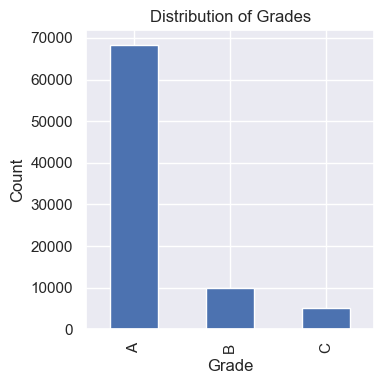

<Figure size 640x480 with 0 Axes>

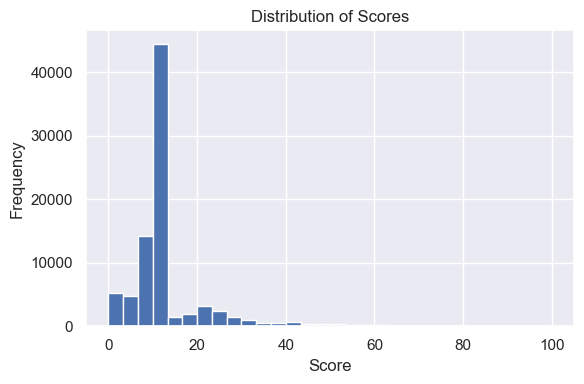


Grades by BORO:
GRADE              A     B     C
BORO                            
Bronx           5943  1020   472
Brooklyn       17929  2722  1456
Manhattan      25955  3366  1844
Queens         15828  2529  1329
Staten Island   2766   335   109


<Figure size 640x480 with 0 Axes>

<Figure size 800x500 with 0 Axes>

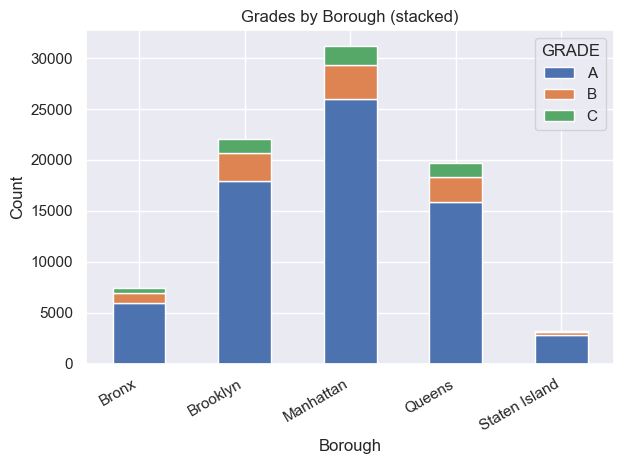


Average SCORE by year:
INSPECTION_YEAR
2012     7.000000
2013     2.500000
2015     8.000000
2016     9.719231
2017    10.506893
2018    11.560417
2019    12.689880
2020    12.378433
2021    12.305988
2022    13.243497
2023    13.889556
Name: SCORE, dtype: float64


<Figure size 640x480 with 0 Axes>

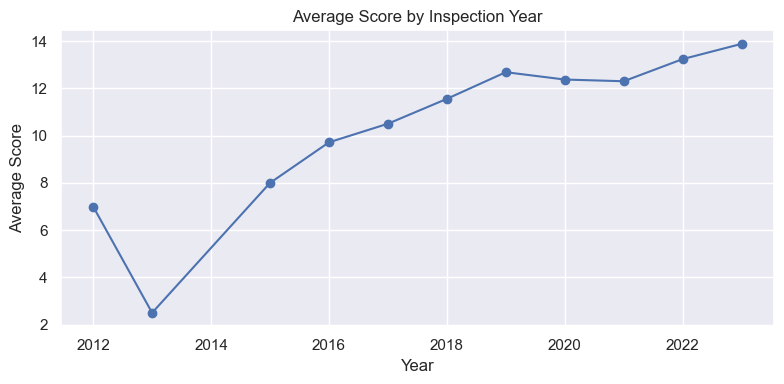

<Figure size 640x480 with 0 Axes>

In [27]:
def show_and_clear():
    plt.tight_layout()
    plt.show()
    plt.clf()

# 4.1 Grade distribution
print("\nGrade counts:")
print(df["GRADE"].value_counts())

plt.figure(figsize=(4, 4))
df["GRADE"].value_counts().loc[["A", "B", "C"]].plot(kind="bar")
plt.title("Distribution of Grades")
plt.xlabel("Grade")
plt.ylabel("Count")
show_and_clear()

# 4.2 Score distribution
plt.figure(figsize=(6, 4))
df["SCORE"].plot(kind="hist", bins=30)
plt.title("Distribution of Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
show_and_clear()

# 4.3 Grades by borough
print("\nGrades by BORO:")
print(pd.crosstab(df["BORO"], df["GRADE"]))

plt.figure(figsize=(8, 5))
(pd.crosstab(df["BORO"], df["GRADE"])
   .loc[:, ["A", "B", "C"]]
   .plot(kind="bar", stacked=True))
plt.title("Grades by Borough (stacked)")
plt.xlabel("Borough")
plt.ylabel("Count")
plt.xticks(rotation=30, ha="right")
show_and_clear()

# 4.4 Average score by year
yearly_scores = df.groupby("INSPECTION_YEAR")["SCORE"].mean().sort_index()
print("\nAverage SCORE by year:")
print(yearly_scores)

plt.figure(figsize=(8, 4))
yearly_scores.plot(marker="o")
plt.title("Average Score by Inspection Year")
plt.xlabel("Year")
plt.ylabel("Average Score")
show_and_clear()

## Simple Feature Engineering

In [28]:
# Set categorical types for key columns used in modeling
for col in ["BORO", "CUISINE DESCRIPTION", "INSPECTION TYPE"]:
    if col in df.columns:
        df[col] = df[col].astype("category")

## Feature Matrix for Modeling

In [29]:
# --- Pre-inspection features only ---
feature_cols = [
    # Geographic features
    "Latitude",
    "Longitude",
    "BORO",
    "ZIPCODE",           # Neighborhood-level geographic feature
    "NTA",               # Neighborhood Tabulation Area
    "Community Board",   # Administrative boundary
    # Restaurant characteristics
    "CUISINE DESCRIPTION",
    # Temporal features
    "INSPECTION_YEAR",
    "INSPECTION_MONTH",
    # Restaurant history features (Phase 1)
    "num_prior_inspections",      # Number of prior inspections for this restaurant
    "prev_grade",                 # Grade from previous inspection
    "days_since_last_inspection", # Days since last inspection
]

X = df[feature_cols].copy()
y = df["GRADE"].copy()
groups = df["CAMIS"]  # still needed for grouped splitting

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique restaurants:", groups.nunique())

X shape: (83603, 12)
y shape: (83603,)
Unique restaurants: 21165


## Grouped 70/30 Train-test Split

In [30]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (58336, 12)
Test size: (25267, 12)


## SMOTE Upsampling for Class Imbalance

=== BEFORE SMOTE ===
Train set class distribution:
GRADE
A         47816
B          6863
C          3657
Closed        0
N             0
P             0
Z             0
Name: count, dtype: int64

Class proportions:
  A: 47,816 (82.0%)
  B: 6,863 (11.8%)
  C: 3,657 (6.3%)

=== AFTER SMOTE ===
Train set class distribution:
GRADE
A    47816
B    47816
C    47816
Name: count, dtype: int64

Class proportions:
  A: 47,816 (33.3%)
  B: 47,816 (33.3%)
  C: 47,816 (33.3%)

Original train size: 58,336
After SMOTE train size: 143,448
Increase: 85,112 samples (145.9%)


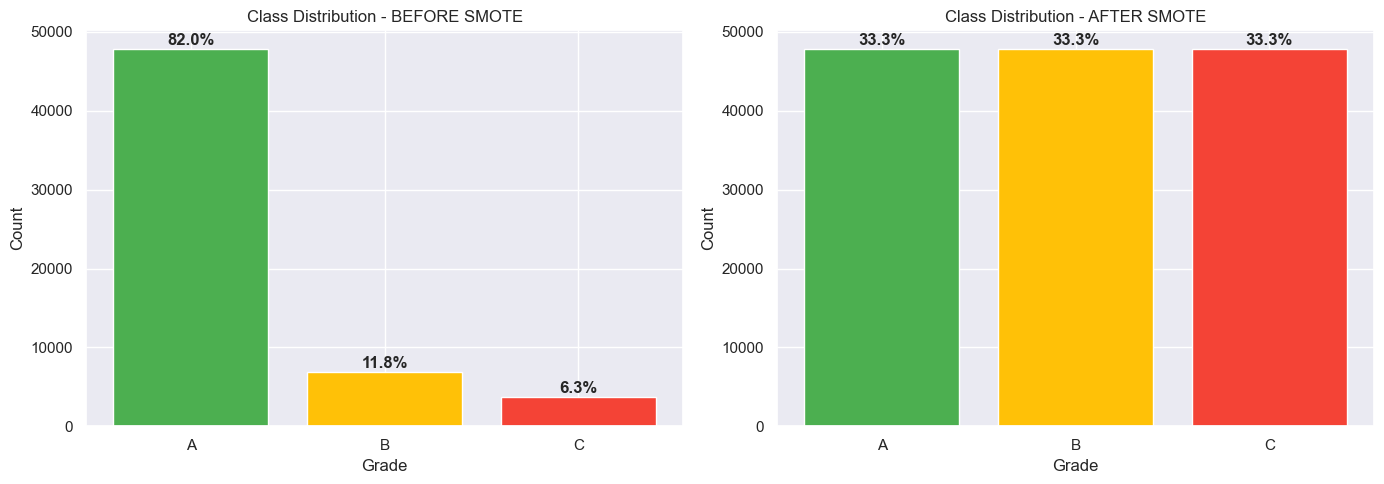

In [31]:
# Apply SMOTE to balance classes B and C
# SMOTE creates synthetic samples for minority classes

print("=== BEFORE SMOTE ===")
print("Train set class distribution:")
print(y_train.value_counts().sort_index())
print(f"\nClass proportions:")
for grade in ["A", "B", "C"]:
    count = (y_train == grade).sum()
    pct = count / len(y_train) * 100
    print(f"  {grade}: {count:,} ({pct:.1f}%)")

# First, we need to preprocess the data before applying SMOTE
# SMOTE works on numeric features, so we need to encode categoricals first
preprocess_temp = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["BORO", "CUISINE DESCRIPTION", "ZIPCODE", "NTA", "Community Board", "prev_grade"]),
        ("num", "passthrough", ["Latitude", "Longitude", "INSPECTION_YEAR", "INSPECTION_MONTH", "num_prior_inspections", "days_since_last_inspection"]),
    ]
)

# Transform training data
X_train_encoded = preprocess_temp.fit_transform(X_train)

# Convert y_train to numeric for SMOTE FIRST (it needs numeric labels)
# This must be done before creating SMOTE with sampling_strategy
label_to_int = {"A": 0, "B": 1, "C": 2}
y_train_encoded = y_train.map(label_to_int)

# Calculate target counts based on encoded labels
# Class 0 (A) is the majority class
target_count_class_0 = (y_train_encoded == 0).sum()

# Apply SMOTE
# Strategy: upsample classes 1 (B) and 2 (C) to match class 0 (A)'s count
# IMPORTANT: Use numeric keys (0, 1, 2) that match the encoded labels
smote = SMOTE(
    sampling_strategy={0: target_count_class_0,  # Keep class 0 (A) as is
                      1: target_count_class_0,  # Upsample class 1 (B) to match A
                      2: target_count_class_0},  # Upsample class 2 (C) to match A
    random_state=42,
    k_neighbors=5  # Number of nearest neighbors for SMOTE
)

# Apply SMOTE
X_train_smote, y_train_smote_encoded = smote.fit_resample(X_train_encoded, y_train_encoded)

# Convert back to original labels
int_to_label = {0: "A", 1: "B", 2: "C"}
y_train_smote = pd.Series(y_train_smote_encoded).map(int_to_label)

print("\n=== AFTER SMOTE ===")
print("Train set class distribution:")
print(y_train_smote.value_counts().sort_index())
print(f"\nClass proportions:")
for grade in ["A", "B", "C"]:
    count = (y_train_smote == grade).sum()
    pct = count / len(y_train_smote) * 100
    print(f"  {grade}: {count:,} ({pct:.1f}%)")

print(f"\nOriginal train size: {len(y_train):,}")
print(f"After SMOTE train size: {len(y_train_smote):,}")
print(f"Increase: {len(y_train_smote) - len(y_train):,} samples ({((len(y_train_smote) / len(y_train)) - 1) * 100:.1f}%)")

# Visualize the class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
before_counts = y_train.value_counts().sort_index()
axes[0].bar(["A", "B", "C"], [before_counts["A"], before_counts["B"], before_counts["C"]], 
            color=["#4CAF50", "#FFC107", "#F44336"])
axes[0].set_title("Class Distribution - BEFORE SMOTE")
axes[0].set_xlabel("Grade")
axes[0].set_ylabel("Count")
for i, grade in enumerate(["A", "B", "C"]):
    count = before_counts[grade]
    pct = count / len(y_train) * 100
    axes[0].text(i, count + 500, f"{pct:.1f}%", ha="center", fontweight="bold")

# After SMOTE
after_counts = y_train_smote.value_counts().sort_index()
axes[1].bar(["A", "B", "C"], [after_counts["A"], after_counts["B"], after_counts["C"]], 
            color=["#4CAF50", "#FFC107", "#F44336"])
axes[1].set_title("Class Distribution - AFTER SMOTE")
axes[1].set_xlabel("Grade")
axes[1].set_ylabel("Count")
for i, grade in enumerate(["A", "B", "C"]):
    count = after_counts[grade]
    pct = count / len(y_train_smote) * 100
    axes[1].text(i, count + 500, f"{pct:.1f}%", ha="center", fontweight="bold")

plt.tight_layout()
plt.show()

# Note: X_train_smote is now a numpy array (encoded features)
# We'll need to use this for training models with SMOTE
# The original X_train (DataFrame) is preserved for reference


## Preprocessing for Categorical Variables

In [32]:
categorical_cols = ["BORO", "CUISINE DESCRIPTION", "ZIPCODE", "NTA", "Community Board", "prev_grade"]
numeric_cols = ["Latitude", "Longitude", "INSPECTION_YEAR", "INSPECTION_MONTH", "num_prior_inspections", "days_since_last_inspection"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

## Logistic Regression Model

In [33]:
# Logistic Regression - Linear baseline model for comparison
# Uses multinomial logistic regression for multi-class classification

def classification_report_df(y_true, y_pred):
    """Convert sklearn classification_report to pandas DataFrame."""
    report = classification_report(y_true, y_pred, output_dict=True)
    return pd.DataFrame(report).transpose()
    
lr_model = LogisticRegression(
    multi_class="multinomial",  # For multi-class classification
    solver="lbfgs",  # Good for small-medium datasets
    max_iter=1500,  # Increase iterations for convergence
    class_weight="balanced",  # Handle class imbalance
    random_state=42,
    n_jobs=-1
)

# Build pipeline: preprocess → model
lr_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", lr_model),
])

# Train the model
lr_pipeline.fit(X_train, y_train)

# =============================
#        TRAIN EVALUATION
# =============================
y_train_pred = lr_pipeline.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

print("=== Logistic Regression TRAIN ACCURACY ===", train_acc)

train_report_df = classification_report_df(y_train, y_train_pred)

print("\n=== Logistic Regression TRAIN CLASSIFICATION REPORT ===")
display(train_report_df)

# =============================
#        TEST EVALUATION
# =============================
y_test_pred = lr_pipeline.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n=== Logistic Regression TEST ACCURACY ===", test_acc)

test_report_df = classification_report_df(y_test, y_test_pred)

print("\n=== Logistic Regression TEST CLASSIFICATION REPORT ===")
display(test_report_df)


/Users/nghia.lam/Desktop/Data_Mining_Fall_2025/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/nghia.lam/Desktop/Data_Mining_Fall_2025/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression TRAIN ACCURACY === 0.9324259462424574

=== Logistic Regression TRAIN CLASSIFICATION REPORT ===


,precision,recall,f1-score,support
A,0.964462,0.956354,0.960391,47816.000000
B,0.756468,0.805187,0.780068,6863.000000
C,0.867846,0.858354,0.863074,3657.000000
accuracy,0.932426,0.932426,0.932426,0.932426
macro avg,0.862925,0.873298,0.867844,58336.000000
weighted avg,0.933936,0.932426,0.933076,58336.000000



=== Logistic Regression TEST ACCURACY === 0.9305813907468239

=== Logistic Regression TEST CLASSIFICATION REPORT ===


,precision,recall,f1-score,support
A,0.962091,0.955787,0.958929,20605.000000
B,0.758275,0.803152,0.780069,3109.000000
C,0.878989,0.851256,0.864900,1553.000000
accuracy,0.930581,0.930581,0.930581,0.930581
macro avg,0.866452,0.870065,0.867966,25267.000000
weighted avg,0.931904,0.930581,0.931141,25267.000000


## Random Forest Classifier Model

In [34]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf_model),
])

pipeline.fit(X_train, y_train)

# --- TRAIN EVAL ---
y_train_pred = pipeline.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

print("=== Random Forest Classifier TRAIN ACCURACY ===", train_acc)

train_report_df = classification_report_df(y_train, y_train_pred)

print("\n=== Random Forest Classifier TRAIN REPORT ===")
display(train_report_df)


# --- TEST EVAL ---
y_test_pred = pipeline.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print("=== Random Forest Classifier TEST ACCURACY ===", test_acc)

test_report_df = classification_report_df(y_test, y_test_pred)

print("\n=== Random Forest Classifier TEST CLASSIFICATION REPORT ===")
display(test_report_df)


=== Random Forest Classifier TRAIN ACCURACY === 0.9999828579264948

=== Random Forest Classifier TRAIN REPORT ===


,precision,recall,f1-score,support
A,1.000000,0.999979,0.999990,47816.000000
B,1.000000,1.000000,1.000000,6863.000000
C,0.999727,1.000000,0.999863,3657.000000
accuracy,0.999983,0.999983,0.999983,0.999983
macro avg,0.999909,0.999993,0.999951,58336.000000
weighted avg,0.999983,0.999983,0.999983,58336.000000


=== Random Forest Classifier TEST ACCURACY === 0.9593145209166106

=== Random Forest Classifier TEST CLASSIFICATION REPORT ===


,precision,recall,f1-score,support
A,0.954383,0.998107,0.975756,20605.000000
B,0.986244,0.761016,0.859114,3109.000000
C,0.990902,0.841597,0.910167,1553.000000
accuracy,0.959315,0.959315,0.959315,0.959315
macro avg,0.977177,0.866907,0.915012,25267.000000
weighted avg,0.960548,0.959315,0.957372,25267.000000


## XGBoost Model

In [35]:
# -----------------------------
# 1. Encode labels A/B/C → 0/1/2
# -----------------------------
label_to_int = {"A": 0, "B": 1, "C": 2}
int_to_label = {v: k for k, v in label_to_int.items()}

y_train_enc = y_train.map(label_to_int)
y_test_enc  = y_test.map(label_to_int)

# -----------------------------
# 2. Compute sample weights to handle class imbalance
#    (still based on original labels, that's fine)
# -----------------------------
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# -----------------------------
# 3. Define XGBoost classifier
# -----------------------------
xgb_clf = XGBClassifier(
    objective="multi:softprob",   # probabilistic multi-class
    eval_metric="mlogloss",
    num_class=3,                  # 3 grades: A, B, C
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# -----------------------------
# 4. Build pipeline: preprocess → model
# -----------------------------
xgb_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb_clf),
])

# -----------------------------
# 5. Train with encoded labels
# -----------------------------
xgb_pipeline.fit(
    X_train,
    y_train_enc,
    model__sample_weight=sample_weights
)

# =============================
#        TRAIN EVALUATION
# =============================
y_train_pred_enc = xgb_pipeline.predict(X_train)
# convert back to A/B/C for reporting
y_train_pred = pd.Series(y_train_pred_enc).map(int_to_label)

train_acc = accuracy_score(y_train, y_train_pred)
print("=== XGBoost TRAIN ACCURACY ===", train_acc)

train_report_df = classification_report_df(y_train, y_train_pred)

print("\n=== XGBoost TRAIN CLASSIFICATION REPORT ===")
display(train_report_df)

# =============================
#        TEST EVALUATION
# =============================
y_test_pred_enc = xgb_pipeline.predict(X_test)
y_test_pred = pd.Series(y_test_pred_enc).map(int_to_label)

test_acc = accuracy_score(y_test, y_test_pred)
print("\n=== XGBoost TEST ACCURACY ===", test_acc)

test_report_df = classification_report_df(y_test, y_test_pred)

print("\n=== XGBoost TEST CLASSIFICATION REPORT ===")
display(test_report_df)


=== XGBoost TRAIN ACCURACY === 0.9377571311025782

=== XGBoost TRAIN CLASSIFICATION REPORT ===


,precision,recall,f1-score,support
A,0.977127,0.948825,0.962768,47816.000000
B,0.739301,0.878479,0.802903,6863.000000
C,0.881867,0.904293,0.892939,3657.000000
accuracy,0.937757,0.937757,0.937757,0.937757
macro avg,0.866098,0.910532,0.886203,58336.000000
weighted avg,0.943176,0.937757,0.939583,58336.000000



=== XGBoost TEST ACCURACY === 0.9242885977757549

=== XGBoost TEST CLASSIFICATION REPORT ===


,precision,recall,f1-score,support
A,0.968797,0.943266,0.955861,20605.000000
B,0.718490,0.832422,0.771271,3109.000000
C,0.829694,0.856407,0.842839,1553.000000
accuracy,0.924289,0.924289,0.924289,0.924289
macro avg,0.838994,0.877365,0.856657,25267.000000
weighted avg,0.929448,0.924289,0.926201,25267.000000


## CatBoost Model

In [36]:
# -----------------------------
# 1. Encode labels A/B/C → 0/1/2
# -----------------------------
# Reuse the same label mappings from XGBoost
label_to_int = {"A": 0, "B": 1, "C": 2}
int_to_label = {v: k for k, v in label_to_int.items()}

y_train_enc = y_train.map(label_to_int)
y_test_enc  = y_test.map(label_to_int)

# -----------------------------
# 2. Prepare data for CatBoost with RAW categorical features
#    CatBoost's superpower is handling categorical features natively!
#    We'll use the raw DataFrame, not one-hot encoded
# -----------------------------
# Create copies of train/test with proper data types
X_train_cb = X_train.copy()
X_test_cb = X_test.copy()

# Ensure categorical columns are properly typed
categorical_feature_names = ["BORO", "CUISINE DESCRIPTION", "ZIPCODE", "NTA", "Community Board", "prev_grade"]
for col in categorical_feature_names:
    X_train_cb[col] = X_train_cb[col].astype("category")
    X_test_cb[col] = X_test_cb[col].astype("category")

# Identify categorical feature indices (0-indexed positions in the DataFrame)
categorical_indices = [X_train_cb.columns.get_loc(col) for col in categorical_feature_names]

print("Categorical feature indices:", categorical_indices)
print("Categorical features:", categorical_feature_names)

# -----------------------------
# 3. Use GENTLE, hand-tuned class weights (not auto-computed "balanced")
#    The prescription: A=1.0, B=2.0, C=3.0 or 4.0
#    This is a "nudge" not a "threat"
# -----------------------------
# Start with gentle weights: A=1.0, B=2.0, C=3.0
class_weights_list = [1.0, 2.0, 3.0]  # [weight_A, weight_B, weight_C]

print("\nUsing gentle class weights:")
print(f"  Class A (majority): {class_weights_list[0]}")
print(f"  Class B: {class_weights_list[1]}")
print(f"  Class C (minority): {class_weights_list[2]}")

# -----------------------------
# 4. Define CatBoost classifier with increased capacity
#    Depth: 6-8, Iterations: 500-800, Learning rate: 0.05-0.1
# -----------------------------
catboost_clf = CatBoostClassifier(
    iterations=600,  # Increased from 300
    depth=6,  # Increased from 4
    learning_rate=0.05,  # Slightly lower for more stable training
    loss_function="MultiClass",
    eval_metric="MultiClass",
    random_seed=42,
    verbose=False,
    allow_writing_files=False,
    class_weights=class_weights_list,  # Gentle hand-tuned weights
    cat_features=categorical_indices  # Let CatBoost handle categoricals natively!
    # NOTE: NO sample_weight - we're only using class_weights to avoid double-counting
)

# -----------------------------
# 5. Train CatBoost on RAW data (not preprocessed/one-hot encoded)
#    This lets CatBoost use its target-based encoding for categoricals
# -----------------------------
print("\nTraining CatBoost on raw data with native categorical handling...")
catboost_clf.fit(
    X_train_cb,
    y_train_enc
    # NO sample_weight - only using class_weights
)

# =============================
#        TRAIN EVALUATION
# =============================
y_train_pred_enc = catboost_clf.predict(X_train_cb)
# CatBoost returns 2D array, need to flatten it
y_train_pred_enc = y_train_pred_enc.ravel() if len(y_train_pred_enc.shape) > 1 else y_train_pred_enc
# convert back to A/B/C for reporting
y_train_pred = pd.Series(y_train_pred_enc).map(int_to_label)

train_acc = accuracy_score(y_train, y_train_pred)
print("\n=== CatBoost TRAIN ACCURACY ===", train_acc)

train_report_df = classification_report_df(y_train, y_train_pred)

print("\n=== CatBoost TRAIN CLASSIFICATION REPORT ===")
display(train_report_df)

# =============================
#        TEST EVALUATION
# =============================
y_test_pred_enc = catboost_clf.predict(X_test_cb)
# CatBoost returns 2D array, need to flatten it
y_test_pred_enc = y_test_pred_enc.ravel() if len(y_test_pred_enc.shape) > 1 else y_test_pred_enc
y_test_pred = pd.Series(y_test_pred_enc).map(int_to_label)

test_acc = accuracy_score(y_test, y_test_pred)
print("\n=== CatBoost TEST ACCURACY ===", test_acc)

test_report_df = classification_report_df(y_test, y_test_pred)

print("\n=== CatBoost TEST CLASSIFICATION REPORT ===")
display(test_report_df)


Categorical feature indices: [2, 6, 3, 4, 5, 10]
Categorical features: ['BORO', 'CUISINE DESCRIPTION', 'ZIPCODE', 'NTA', 'Community Board', 'prev_grade']

Using gentle class weights:
  Class A (majority): 1.0
  Class B: 2.0
  Class C (minority): 3.0

Training CatBoost on raw data with native categorical handling...

=== CatBoost TRAIN ACCURACY === 0.9671386450905102

=== CatBoost TRAIN CLASSIFICATION REPORT ===


,precision,recall,f1-score,support
A,0.967426,0.993789,0.980430,47816.000000
B,0.963052,0.820341,0.885986,6863.000000
C,0.970039,0.894176,0.930563,3657.000000
accuracy,0.967139,0.967139,0.967139,0.967139
macro avg,0.966839,0.902768,0.932327,58336.000000
weighted avg,0.967075,0.967139,0.966193,58336.000000



=== CatBoost TEST ACCURACY === 0.9547235524597301

=== CatBoost TEST CLASSIFICATION REPORT ===


,precision,recall,f1-score,support
A,0.956033,0.990925,0.973166,20605.000000
B,0.945016,0.768414,0.847614,3109.000000
C,0.952243,0.847392,0.896763,1553.000000
accuracy,0.954724,0.954724,0.954724,0.954724
macro avg,0.951097,0.868910,0.905848,25267.000000
weighted avg,0.954445,0.954724,0.953022,25267.000000


## Models with SMOTE Upsampling

In [37]:
# Train models using SMOTE-upsampled data
# Note: X_train_smote is already preprocessed (encoded), so we'll train directly on it
# X_test still needs to be preprocessed using the same preprocessor

# Preprocess test data using the same preprocessor
X_test_encoded = preprocess_temp.transform(X_test)

print("=" * 70)
print("TRAINING MODELS WITH SMOTE-UPSAMPLED DATA")
print("=" * 70)

# ============================================
# 1. Random Forest with SMOTE
# ============================================
print("\n[1/4] Training Random Forest with SMOTE...")
rf_smote = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
    # Note: No class_weight needed since classes are balanced
)

rf_smote.fit(X_train_smote, y_train_smote_encoded)

# Predictions
y_train_pred_smote_rf = pd.Series(rf_smote.predict(X_train_smote)).map(int_to_label)
y_test_pred_smote_rf = pd.Series(rf_smote.predict(X_test_encoded)).map(int_to_label)

# Evaluation
train_acc_smote_rf = accuracy_score(y_train_smote, y_train_pred_smote_rf)
test_acc_smote_rf = accuracy_score(y_test, y_test_pred_smote_rf)

print(f"  Train Accuracy: {train_acc_smote_rf:.4f}")
print(f"  Test Accuracy: {test_acc_smote_rf:.4f}")

# ============================================
# 2. XGBoost with SMOTE
# ============================================
print("\n[2/4] Training XGBoost with SMOTE...")
xgb_smote = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    num_class=3,
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
    # Note: No sample weights needed since classes are balanced
)

xgb_smote.fit(X_train_smote, y_train_smote_encoded)

# Predictions
y_train_pred_smote_xgb = pd.Series(xgb_smote.predict(X_train_smote)).map(int_to_label)
y_test_pred_smote_xgb = pd.Series(xgb_smote.predict(X_test_encoded)).map(int_to_label)

# Evaluation
train_acc_smote_xgb = accuracy_score(y_train_smote, y_train_pred_smote_xgb)
test_acc_smote_xgb = accuracy_score(y_test, y_test_pred_smote_xgb)

print(f"  Train Accuracy: {train_acc_smote_xgb:.4f}")
print(f"  Test Accuracy: {test_acc_smote_xgb:.4f}")

# ============================================
# 3. Logistic Regression with SMOTE
# ============================================
print("\n[3/4] Training Logistic Regression with SMOTE...")
lr_smote = LogisticRegression(
    solver="lbfgs",
    max_iter=1500,
    random_state=42,
    n_jobs=-1
    # Note: No class_weight needed since classes are balanced
)

lr_smote.fit(X_train_smote, y_train_smote_encoded)

# Predictions
y_train_pred_smote_lr = pd.Series(lr_smote.predict(X_train_smote)).map(int_to_label)
y_test_pred_smote_lr = pd.Series(lr_smote.predict(X_test_encoded)).map(int_to_label)

# Evaluation
train_acc_smote_lr = accuracy_score(y_train_smote, y_train_pred_smote_lr)
test_acc_smote_lr = accuracy_score(y_test, y_test_pred_smote_lr)

print(f"  Train Accuracy: {train_acc_smote_lr:.4f}")
print(f"  Test Accuracy: {test_acc_smote_lr:.4f}")

# ============================================
# 4. CatBoost with SMOTE
# ============================================
print("\n[4/4] Training CatBoost with SMOTE...")
catboost_smote = CatBoostClassifier(
    iterations=300,
    depth=4,
    learning_rate=0.1,
    loss_function="MultiClass",
    eval_metric="MultiClass",
    random_seed=42,
    verbose=False,
    allow_writing_files=False  # Prevent creation of catboost_info folder
    # Note: No class weights needed since classes are balanced
)

catboost_smote.fit(X_train_smote, y_train_smote_encoded)

# Predictions
# CatBoost returns 2D array, need to flatten it
y_train_pred_smote_cb_enc = catboost_smote.predict(X_train_smote)
y_train_pred_smote_cb_enc = y_train_pred_smote_cb_enc.ravel() if len(y_train_pred_smote_cb_enc.shape) > 1 else y_train_pred_smote_cb_enc
y_train_pred_smote_cb = pd.Series(y_train_pred_smote_cb_enc).map(int_to_label)

y_test_pred_smote_cb_enc = catboost_smote.predict(X_test_encoded)
y_test_pred_smote_cb_enc = y_test_pred_smote_cb_enc.ravel() if len(y_test_pred_smote_cb_enc.shape) > 1 else y_test_pred_smote_cb_enc
y_test_pred_smote_cb = pd.Series(y_test_pred_smote_cb_enc).map(int_to_label)

# Evaluation
train_acc_smote_cb = accuracy_score(y_train_smote, y_train_pred_smote_cb)
test_acc_smote_cb = accuracy_score(y_test, y_test_pred_smote_cb)

print(f"  Train Accuracy: {train_acc_smote_cb:.4f}")
print(f"  Test Accuracy: {test_acc_smote_cb:.4f}")

print("\n" + "=" * 70)


TRAINING MODELS WITH SMOTE-UPSAMPLED DATA

[1/4] Training Random Forest with SMOTE...
  Train Accuracy: 1.0000
  Test Accuracy: 0.9576

[2/4] Training XGBoost with SMOTE...
  Train Accuracy: 0.9726
  Test Accuracy: 0.9605

[3/4] Training Logistic Regression with SMOTE...


/Users/nghia.lam/Desktop/Data_Mining_Fall_2025/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Train Accuracy: 0.8986
  Test Accuracy: 0.9440

[4/4] Training CatBoost with SMOTE...
  Train Accuracy: 0.9542
  Test Accuracy: 0.9596



## Hyperparameter Tuning with Grid Search

To optimize model performance, we'll perform systematic hyperparameter tuning using grid search and randomized search. This will help us find the best parameters for each model.

**Strategy**:
- **GridSearchCV** for Logistic Regression and Random Forest (smaller parameter spaces)
- **RandomizedSearchCV** for XGBoost and CatBoost (larger parameter spaces, more efficient)
- **GroupShuffleSplit** for cross-validation to prevent restaurant leakage
- **F1-score (macro)** as the scoring metric (balances all classes)
- Optimize both **class_weight** and **SMOTE** approaches

In [38]:
# Hyperparameter Tuning with Grid Search
# This will systematically search for the best hyperparameters for each model

print("=" * 70)
print("HYPERPARAMETER TUNING WITH GRID SEARCH")
print("=" * 70)

# Prepare groups for GroupShuffleSplit (to prevent restaurant leakage)
# X_train was created from df, so we can map its index back to CAMIS
# If index was preserved, use directly; otherwise we need to reconstruct
try:
    # Try to use index directly (if preserved from original df)
    groups_train = df.loc[X_train.index, "CAMIS"].values
except (KeyError, IndexError):
    # If index was reset, we need to reconstruct from the original split
    # Recreate the split to get train_idx
    gss_temp = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
    X_temp = df[feature_cols].copy()
    y_temp = df["GRADE"].copy()
    groups_temp = df["CAMIS"]
    train_idx_temp, _ = next(gss_temp.split(X_temp, y_temp, groups=groups_temp))
    groups_train = groups_temp.iloc[train_idx_temp].values

# Create GroupShuffleSplit for cross-validation
cv = GroupShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

# Store best models
best_models = {}

print("\n[1/4] Tuning Logistic Regression...")
print("-" * 70)

# Logistic Regression - Grid Search
# Note: multi_class parameter not included (deprecated, multinomial is now default)
lr_param_grid = {
    "model__C": [0.1, 1.0, 10.0, 100.0],
    "model__solver": ["lbfgs", "liblinear"],
    "model__max_iter": [1500, 2000, 2500]  # Increased range for better convergence
}

lr_grid = GridSearchCV(
    lr_pipeline,
    param_grid=lr_param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

lr_grid.fit(X_train, y_train, groups=groups_train)
best_models["lr"] = lr_grid.best_estimator_
print(f"Best parameters: {lr_grid.best_params_}")
print(f"Best CV F1-score (macro): {lr_grid.best_score_:.4f}")

print("\n[2/4] Tuning Random Forest...")
print("-" * 70)

# Random Forest - Grid Search
rf_param_grid = {
    "model__n_estimators": [200, 300, 400],
    "model__max_depth": [10, 20, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}

rf_grid = GridSearchCV(
    pipeline,
    param_grid=rf_param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train, groups=groups_train)
best_models["rf"] = rf_grid.best_estimator_
print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best CV F1-score (macro): {rf_grid.best_score_:.4f}")

print("\n[3/4] Tuning XGBoost...")
print("-" * 70)

# XGBoost requires encoded labels (0, 1, 2) instead of string labels (A, B, C)
# Reuse the same label encoding from the XGBoost model training cell
label_to_int = {"A": 0, "B": 1, "C": 2}
y_train_enc = y_train.map(label_to_int)

# Compute sample weights for class imbalance handling
# (compute_sample_weight is already imported at the top of the notebook)
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# XGBoost - Randomized Search (larger parameter space)
xgb_param_dist = {
    "model__n_estimators": [200, 300, 400, 500],
    "model__max_depth": [3, 4, 5, 6],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__subsample": [0.7, 0.8, 0.9],
    "model__colsample_bytree": [0.7, 0.8, 0.9],
    "model__gamma": [0, 0.1, 0.2]
}

xgb_random = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=xgb_param_dist,
    n_iter=30,  # Number of parameter settings sampled
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# XGBoost requires encoded labels and sample weights
xgb_random.fit(X_train, y_train_enc, groups=groups_train, 
               model__sample_weight=sample_weights)
best_models["xgb"] = xgb_random.best_estimator_
print(f"Best parameters: {xgb_random.best_params_}")
print(f"Best CV F1-score (macro): {xgb_random.best_score_:.4f}")

print("\n[4/4] Tuning CatBoost...")
print("-" * 70)

# CatBoost - Randomized Search
# Note: CatBoost uses raw features, so we need to use X_train_cb
groups_train_cb = df.loc[X_train_cb.index, "CAMIS"].values

catboost_param_dist = {
    "iterations": [400, 500, 600, 700],
    "depth": [4, 5, 6, 7],
    "learning_rate": [0.03, 0.05, 0.07, 0.1],
    "l2_leaf_reg": [1, 3, 5, 7],
    "border_count": [32, 64, 128]
}

catboost_random = RandomizedSearchCV(
    CatBoostClassifier(
        loss_function="MultiClass",
        eval_metric="MultiClass",
        random_seed=42,
        verbose=False,
        allow_writing_files=False,
        class_weights=class_weights_list,
        cat_features=categorical_indices
    ),
    param_distributions=catboost_param_dist,
    n_iter=20,  # Fewer iterations due to longer training time
    cv=cv,
    scoring="f1_macro",
    n_jobs=1,  # CatBoost handles parallelism internally
    random_state=42,
    verbose=1
)

catboost_random.fit(X_train_cb, y_train_enc, groups=groups_train_cb)
best_models["catboost"] = catboost_random.best_estimator_
print(f"Best parameters: {catboost_random.best_params_}")
print(f"Best CV F1-score (macro): {catboost_random.best_score_:.4f}")

print("\n" + "=" * 70)
print("GRID SEARCH COMPLETE")
print("=" * 70)


HYPERPARAMETER TUNING WITH GRID SEARCH

[1/4] Tuning Logistic Regression...
----------------------------------------------------------------------
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/nghia.lam/Desktop/Data_Mining_Fall_2025/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/nghia.lam/Desktop/Data_Mining_Fall_2025/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/nghia.lam/Desktop/Data_Mining_Fall_2025/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/nghia.lam/De

Best parameters: {'model__C': 0.1, 'model__max_iter': 1500, 'model__solver': 'lbfgs'}
Best CV F1-score (macro): 0.8785

[2/4] Tuning Random Forest...
----------------------------------------------------------------------
Fitting 3 folds for each of 81 candidates, totalling 243 fits


/Users/nghia.lam/Desktop/Data_Mining_Fall_2025/myenv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best CV F1-score (macro): 0.9160

[3/4] Tuning XGBoost...
----------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/Users/nghia.lam/Desktop/Data_Mining_Fall_2025/myenv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'model__subsample': 0.8, 'model__n_estimators': 300, 'model__max_depth': 3, 'model__learning_rate': 0.01, 'model__gamma': 0.2, 'model__colsample_bytree': 0.8}
Best CV F1-score (macro): 0.9029

[4/4] Tuning CatBoost...
----------------------------------------------------------------------
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 700, 'depth': 7, 'border_count': 64}
Best CV F1-score (macro): 0.9084

GRID SEARCH COMPLETE


## Hyperparameter Tuning with Grid Search - SMOTE Approach

**Strategy**:
- Use the same parameter grids as class_weight approach for fair comparison
- Train on SMOTE-upsampled data (`X_train_smote`, `y_train_smote_encoded`)
- Use **StratifiedKFold** for cross-validation (groups less critical after SMOTE upsampling)
- **F1-score (macro)** as the scoring metric (balances all classes)
- Compare best SMOTE models vs best class_weight models

In [39]:
# Hyperparameter Tuning with Grid Search - SMOTE Approach
# This systematically searches for the best hyperparameters for SMOTE-upsampled models

from sklearn.model_selection import StratifiedKFold

print("=" * 70)
print("HYPERPARAMETER TUNING - SMOTE APPROACH")
print("=" * 70)

# For SMOTE, we use StratifiedKFold since groups are less critical after upsampling
# SMOTE creates synthetic samples, so maintaining exact restaurant groups is less important
cv_smote = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Store best SMOTE models
best_models_smote = {}

print("\n[1/4] Tuning Logistic Regression with SMOTE...")
print("-" * 70)

# Logistic Regression with SMOTE - Grid Search
# Note: No class_weight needed since SMOTE balances classes
lr_param_grid_smote = {
    "C": [0.1, 1.0, 10.0, 100.0],
    "solver": ["lbfgs", "liblinear"],
    "max_iter": [1000, 1500, 2000]
}

lr_smote_grid = GridSearchCV(
    LogisticRegression(random_state=42, n_jobs=-1),
    param_grid=lr_param_grid_smote,
    cv=cv_smote,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

lr_smote_grid.fit(X_train_smote, y_train_smote_encoded)
best_models_smote["lr"] = lr_smote_grid.best_estimator_
print(f"Best parameters: {lr_smote_grid.best_params_}")
print(f"Best CV F1-score (macro): {lr_smote_grid.best_score_:.4f}")

print("\n[2/4] Tuning Random Forest with SMOTE...")
print("-" * 70)

# Random Forest with SMOTE - Grid Search
# Note: No class_weight needed since SMOTE balances classes
rf_param_grid_smote = {
    "n_estimators": [200, 300, 400],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf_smote_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid_smote,
    cv=cv_smote,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

rf_smote_grid.fit(X_train_smote, y_train_smote_encoded)
best_models_smote["rf"] = rf_smote_grid.best_estimator_
print(f"Best parameters: {rf_smote_grid.best_params_}")
print(f"Best CV F1-score (macro): {rf_smote_grid.best_score_:.4f}")

print("\n[3/4] Tuning XGBoost with SMOTE...")
print("-" * 70)

# XGBoost with SMOTE - Randomized Search
# Note: No sample_weight needed since SMOTE balances classes
xgb_param_dist_smote = {
    "n_estimators": [200, 300, 400, 500],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "gamma": [0, 0.1, 0.2]
}

xgb_smote_random = RandomizedSearchCV(
    XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        num_class=3,
        random_state=42,
        n_jobs=-1
    ),
    param_distributions=xgb_param_dist_smote,
    n_iter=30,  # Number of parameter settings sampled
    cv=cv_smote,
    scoring="f1_macro",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

xgb_smote_random.fit(X_train_smote, y_train_smote_encoded)
best_models_smote["xgb"] = xgb_smote_random.best_estimator_
print(f"Best parameters: {xgb_smote_random.best_params_}")
print(f"Best CV F1-score (macro): {xgb_smote_random.best_score_:.4f}")

print("\n[4/4] Tuning CatBoost with SMOTE...")
print("-" * 70)

# CatBoost with SMOTE - Randomized Search
# Note: CatBoost with SMOTE uses encoded features (X_train_smote)
# No class weights needed since SMOTE balances classes
catboost_param_dist_smote = {
    "iterations": [400, 500, 600, 700],
    "depth": [4, 5, 6, 7],
    "learning_rate": [0.03, 0.05, 0.07, 0.1],
    "l2_leaf_reg": [1, 3, 5, 7],
    "border_count": [32, 64, 128]
}

catboost_smote_random = RandomizedSearchCV(
    CatBoostClassifier(
        loss_function="MultiClass",
        eval_metric="MultiClass",
        random_seed=42,
        verbose=False,
        allow_writing_files=False
        # No class weights needed since SMOTE balances classes
    ),
    param_distributions=catboost_param_dist_smote,
    n_iter=20,  # Fewer iterations due to longer training time
    cv=cv_smote,
    scoring="f1_macro",
    n_jobs=1,  # CatBoost handles parallelism internally
    random_state=42,
    verbose=1
)

catboost_smote_random.fit(X_train_smote, y_train_smote_encoded)
best_models_smote["catboost"] = catboost_smote_random.best_estimator_
print(f"Best parameters: {catboost_smote_random.best_params_}")
print(f"Best CV F1-score (macro): {catboost_smote_random.best_score_:.4f}")

print("\n" + "=" * 70)
print("SMOTE GRID SEARCH COMPLETE")
print("=" * 70)

HYPERPARAMETER TUNING - SMOTE APPROACH

[1/4] Tuning Logistic Regression with SMOTE...
----------------------------------------------------------------------
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/nghia.lam/Desktop/Data_Mining_Fall_2025/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/nghia.lam/Desktop/Data_Mining_Fall_2025/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
/Users/nghia.lam/Desktop/Data_Mining_Fall_2025/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestC

Best parameters: {'C': 1.0, 'max_iter': 2000, 'solver': 'lbfgs'}
Best CV F1-score (macro): 0.9002

[2/4] Tuning Random Forest with SMOTE...
----------------------------------------------------------------------
Fitting 3 folds for each of 81 candidates, totalling 243 fits


/Users/nghia.lam/Desktop/Data_Mining_Fall_2025/myenv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Best CV F1-score (macro): 0.9819

[3/4] Tuning XGBoost with SMOTE...
----------------------------------------------------------------------
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/Users/nghia.lam/Desktop/Data_Mining_Fall_2025/myenv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'subsample': 0.9, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.8}
Best CV F1-score (macro): 0.9804

[4/4] Tuning CatBoost with SMOTE...
----------------------------------------------------------------------
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'learning_rate': 0.07, 'l2_leaf_reg': 1, 'iterations': 700, 'depth': 6, 'border_count': 128}
Best CV F1-score (macro): 0.9712

SMOTE GRID SEARCH COMPLETE


## Comparing Class Weight vs SMOTE Models Performance

COMPARISON: Class Weight vs SMOTE Upsampling

Test Set Accuracy Comparison:


,Model,Class Weight (Test Acc),SMOTE (Test Acc),Improvement
0,Random Forest,0.9593,0.9576,-0.1702
1,XGBoost,0.9243,0.9605,3.6253
2,CatBoost,0.9547,0.9596,0.4828
3,Logistic Regression,0.9306,0.9440,1.3417


DETAILED PER-CLASS METRICS: Logistic Regression

--- WITH CLASS WEIGHT ---


,precision,recall,f1-score,support
A,0.9621,0.9558,0.9589,20605.0000
B,0.7583,0.8032,0.7801,3109.0000
C,0.8790,0.8513,0.8649,1553.0000
accuracy,0.9306,0.9306,0.9306,0.9306
macro avg,0.8665,0.8701,0.8680,25267.0000
weighted avg,0.9319,0.9306,0.9311,25267.0000



--- WITH SMOTE ---


,precision,recall,f1-score,support
A,0.9585,0.9757,0.9670,20605.000
B,0.8597,0.7806,0.8183,3109.000
C,0.8992,0.8500,0.8739,1553.000
accuracy,0.9440,0.9440,0.9440,0.944
macro avg,0.9058,0.8688,0.8864,25267.000
weighted avg,0.9427,0.9440,0.9430,25267.000



DETAILED PER-CLASS METRICS: Random Forest

--- WITH CLASS WEIGHT ---


,precision,recall,f1-score,support
A,0.9544,0.9981,0.9758,20605.0000
B,0.9862,0.7610,0.8591,3109.0000
C,0.9909,0.8416,0.9102,1553.0000
accuracy,0.9593,0.9593,0.9593,0.9593
macro avg,0.9772,0.8669,0.9150,25267.0000
weighted avg,0.9605,0.9593,0.9574,25267.0000



--- WITH SMOTE ---


,precision,recall,f1-score,support
A,0.9553,0.9951,0.9748,20605.0000
B,0.9647,0.7655,0.8537,3109.0000
C,0.9813,0.8442,0.9076,1553.0000
accuracy,0.9576,0.9576,0.9576,0.9576
macro avg,0.9671,0.8683,0.9120,25267.0000
weighted avg,0.9581,0.9576,0.9558,25267.0000



DETAILED PER-CLASS METRICS: XGBoost

--- WITH CLASS WEIGHT ---


,precision,recall,f1-score,support
A,0.9688,0.9433,0.9559,20605.0000
B,0.7185,0.8324,0.7713,3109.0000
C,0.8297,0.8564,0.8428,1553.0000
accuracy,0.9243,0.9243,0.9243,0.9243
macro avg,0.8390,0.8774,0.8567,25267.0000
weighted avg,0.9294,0.9243,0.9262,25267.0000



--- WITH SMOTE ---


,precision,recall,f1-score,support
A,0.9540,0.9999,0.9764,20605.0000
B,0.9996,0.7594,0.8631,3109.0000
C,0.9977,0.8416,0.9130,1553.0000
accuracy,0.9605,0.9605,0.9605,0.9605
macro avg,0.9838,0.8670,0.9175,25267.0000
weighted avg,0.9623,0.9605,0.9586,25267.0000



DETAILED PER-CLASS METRICS: CatBoost

--- WITH CLASS WEIGHT ---


,precision,recall,f1-score,support
A,0.9560,0.9909,0.9732,20605.0000
B,0.9450,0.7684,0.8476,3109.0000
C,0.9522,0.8474,0.8968,1553.0000
accuracy,0.9547,0.9547,0.9547,0.9547
macro avg,0.9511,0.8689,0.9058,25267.0000
weighted avg,0.9544,0.9547,0.9530,25267.0000



--- WITH SMOTE ---


,precision,recall,f1-score,support
A,0.9542,0.9984,0.9758,20605.0000
B,0.9899,0.7604,0.8601,3109.0000
C,0.9924,0.8422,0.9112,1553.0000
accuracy,0.9596,0.9596,0.9596,0.9596
macro avg,0.9788,0.8670,0.9157,25267.0000
weighted avg,0.9609,0.9596,0.9576,25267.0000


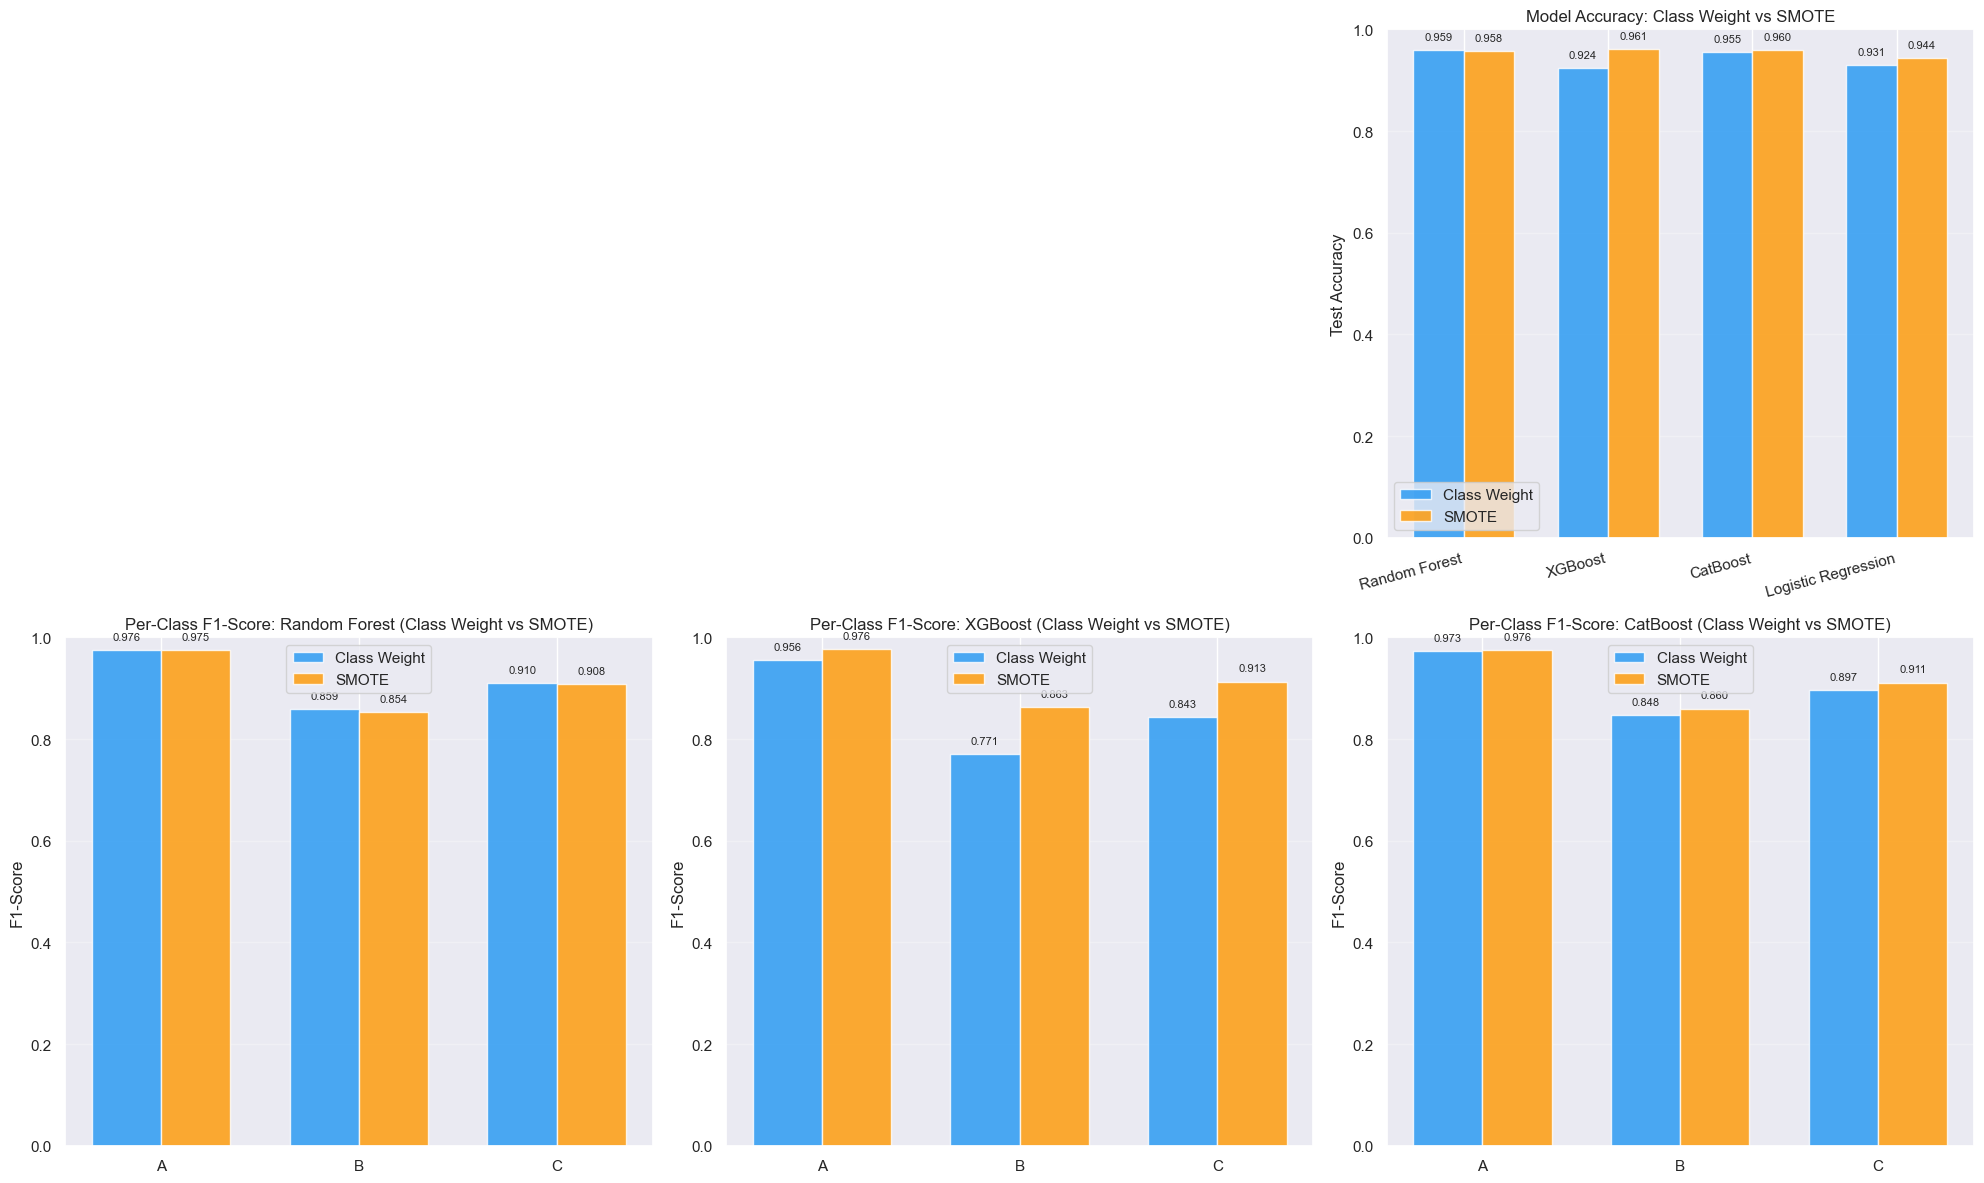

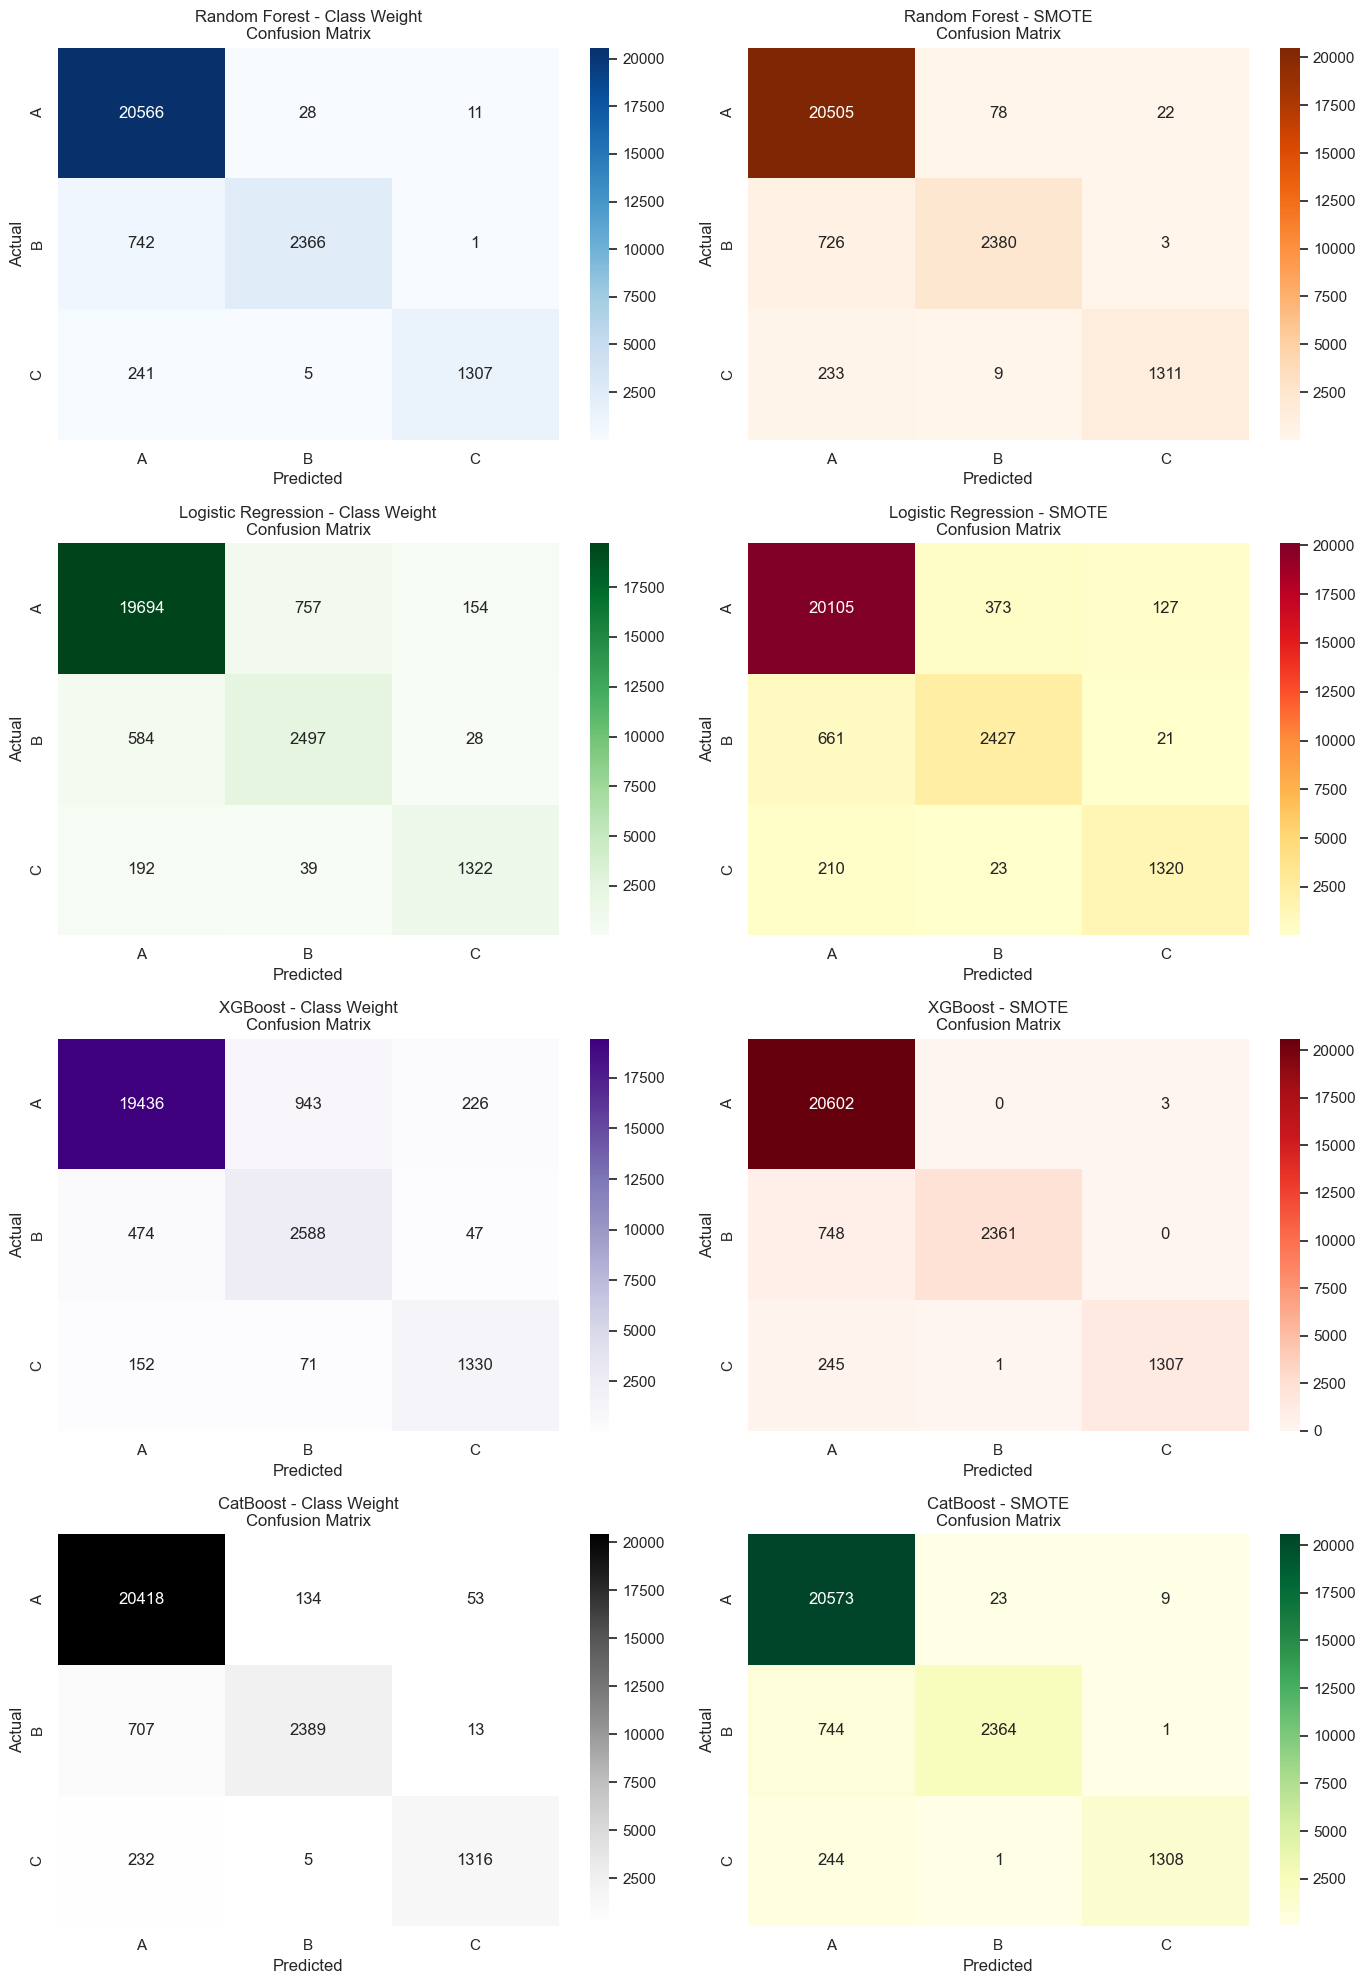


KEY INSIGHTS:
1. SMOTE creates synthetic samples for minority classes (B and C)
2. This should improve recall for B and C classes
3. Compare the confusion matrices to see if B/C predictions improved
4. Check if overall accuracy improved or if it's a trade-off


In [40]:
# Comprehensive comparison: SMOTE vs Class Weight approaches

# Get original model accuracies (from previous cells)
rf_acc_original = accuracy_score(y_test, pipeline.predict(X_test))
xgb_preds_original = pd.Series(xgb_pipeline.predict(X_test)).map({0: "A", 1: "B", 2: "C"})
xgb_acc_original = accuracy_score(y_test, xgb_preds_original)
lr_acc_original = accuracy_score(y_test, lr_pipeline.predict(X_test))
# CatBoost returns 2D array, need to flatten it
# Use X_test_cb (raw data) instead of X_test_processed
cb_preds_original_enc = catboost_clf.predict(X_test_cb)
cb_preds_original_enc = cb_preds_original_enc.ravel() if len(cb_preds_original_enc.shape) > 1 else cb_preds_original_enc
cb_preds_original = pd.Series(cb_preds_original_enc).map({0: "A", 1: "B", 2: "C"})
cb_acc_original = accuracy_score(y_test, cb_preds_original)

# Create comparison DataFrame
comparison_data = {
    "Model": ["Random Forest", "XGBoost", "CatBoost", "Logistic Regression"],
    "Class Weight (Test Acc)": [rf_acc_original, xgb_acc_original, cb_acc_original, lr_acc_original],
    "SMOTE (Test Acc)": [test_acc_smote_rf, test_acc_smote_xgb, test_acc_smote_cb, test_acc_smote_lr],
    "Improvement": [
        test_acc_smote_rf - rf_acc_original,
        test_acc_smote_xgb - xgb_acc_original,
        test_acc_smote_cb - cb_acc_original,
        test_acc_smote_lr - lr_acc_original
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df["Improvement"] = comparison_df["Improvement"] * 100  # Convert to percentage points

print("=" * 70)
print("COMPARISON: Class Weight vs SMOTE Upsampling")
print("=" * 70)
print("\nTest Set Accuracy Comparison:")
display(comparison_df.round(4))

# Detailed per-class metrics for Logistic Regression
print("=" * 70)
print("DETAILED PER-CLASS METRICS: Logistic Regression")
print("=" * 70)

print("\n--- WITH CLASS WEIGHT ---")
lr_report_original = classification_report(y_test, lr_pipeline.predict(X_test), output_dict=True)
lr_df_original = pd.DataFrame(lr_report_original).transpose()
display(lr_df_original.round(4))

print("\n--- WITH SMOTE ---")
lr_report_smote = classification_report(y_test, y_test_pred_smote_lr, output_dict=True)
lr_df_smote = pd.DataFrame(lr_report_smote).transpose()
display(lr_df_smote.round(4))

# Detailed per-class metrics for Random Forest
print("\n" + "=" * 70)
print("DETAILED PER-CLASS METRICS: Random Forest")
print("=" * 70)

print("\n--- WITH CLASS WEIGHT ---")
rf_report_original = classification_report(y_test, pipeline.predict(X_test), output_dict=True)
rf_df_original = pd.DataFrame(rf_report_original).transpose()
display(rf_df_original.round(4))

print("\n--- WITH SMOTE ---")
rf_report_smote = classification_report(y_test, y_test_pred_smote_rf, output_dict=True)
rf_df_smote = pd.DataFrame(rf_report_smote).transpose()
display(rf_df_smote.round(4))

# Detailed per-class metrics for XGBoost
print("\n" + "=" * 70)
print("DETAILED PER-CLASS METRICS: XGBoost")
print("=" * 70)

print("\n--- WITH CLASS WEIGHT ---")
xgb_preds_original = pd.Series(xgb_pipeline.predict(X_test)).map({0: "A", 1: "B", 2: "C"})
xgb_report_original = classification_report(y_test, xgb_preds_original, output_dict=True)
xgb_df_original = pd.DataFrame(xgb_report_original).transpose()
display(xgb_df_original.round(4))

print("\n--- WITH SMOTE ---")
xgb_report_smote = classification_report(y_test, y_test_pred_smote_xgb, output_dict=True)
xgb_df_smote = pd.DataFrame(xgb_report_smote).transpose()
display(xgb_df_smote.round(4))

# Detailed per-class metrics for CatBoost
print("\n" + "=" * 70)
print("DETAILED PER-CLASS METRICS: CatBoost")
print("=" * 70)

print("\n--- WITH CLASS WEIGHT ---")
# CatBoost returns 2D array, need to flatten it (reuse from above if already computed)
if 'cb_preds_original' not in locals():
    cb_preds_original_enc = catboost_clf.predict(X_test_cb)  # Use raw data
    cb_preds_original_enc = cb_preds_original_enc.ravel() if len(cb_preds_original_enc.shape) > 1 else cb_preds_original_enc
    cb_preds_original = pd.Series(cb_preds_original_enc).map({0: "A", 1: "B", 2: "C"})
cb_report_original = classification_report(y_test, cb_preds_original, output_dict=True)
cb_df_original = pd.DataFrame(cb_report_original).transpose()
display(cb_df_original.round(4))

print("\n--- WITH SMOTE ---")
cb_report_smote = classification_report(y_test, y_test_pred_smote_cb, output_dict=True)
cb_df_smote = pd.DataFrame(cb_report_smote).transpose()
display(cb_df_smote.round(4))


# Visual comparison
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Accuracy comparison bar chart (spans 2 columns)
axes[0, 0].axis('off')  # Remove empty subplot
axes[0, 1].axis('off')  # Remove empty subplot
x = np.arange(len(comparison_df))
width = 0.35
axes[0, 2].bar(x - width/2, comparison_df["Class Weight (Test Acc)"], width, 
            label="Class Weight", color="#2196F3", alpha=0.8)
axes[0, 2].bar(x + width/2, comparison_df["SMOTE (Test Acc)"], width, 
            label="SMOTE", color="#FF9800", alpha=0.8)
axes[0, 2].set_ylabel("Test Accuracy")
axes[0, 2].set_title("Model Accuracy: Class Weight vs SMOTE")
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(comparison_df["Model"], rotation=15, ha="right")
axes[0, 2].set_ylim(0, 1)
axes[0, 2].legend()
axes[0, 2].grid(axis="y", alpha=0.3)

# Add value labels
for i, (orig, smote) in enumerate(zip(comparison_df["Class Weight (Test Acc)"], 
                                       comparison_df["SMOTE (Test Acc)"])):
    axes[0, 2].text(i - width/2, orig + 0.02, f"{orig:.3f}", ha="center", fontsize=8)
    axes[0, 2].text(i + width/2, smote + 0.02, f"{smote:.3f}", ha="center", fontsize=8)

# 2. Per-class F1 score comparison (Random Forest)
classes = ["A", "B", "C"]
f1_class_weight_rf = [rf_report_original[cls]["f1-score"] for cls in classes]
f1_smote_rf = [rf_report_smote[cls]["f1-score"] for cls in classes]

x2 = np.arange(len(classes))
axes[1, 0].bar(x2 - width/2, f1_class_weight_rf, width, 
            label="Class Weight", color="#2196F3", alpha=0.8)
axes[1, 0].bar(x2 + width/2, f1_smote_rf, width, 
            label="SMOTE", color="#FF9800", alpha=0.8)
axes[1, 0].set_ylabel("F1-Score")
axes[1, 0].set_title("Per-Class F1-Score: Random Forest (Class Weight vs SMOTE)")
axes[1, 0].set_xticks(x2)
axes[1, 0].set_xticklabels(classes)
axes[1, 0].set_ylim(0, 1)
axes[1, 0].legend()
axes[1, 0].grid(axis="y", alpha=0.3)

# Add value labels for Random Forest
for i, (cw, sm) in enumerate(zip(f1_class_weight_rf, f1_smote_rf)):
    axes[1, 0].text(i - width/2, cw + 0.02, f"{cw:.3f}", ha="center", fontsize=8)
    axes[1, 0].text(i + width/2, sm + 0.02, f"{sm:.3f}", ha="center", fontsize=8)

# 3. Per-class F1 score comparison (XGBoost)
f1_class_weight_xgb = [xgb_report_original[cls]["f1-score"] for cls in classes]
f1_smote_xgb = [xgb_report_smote[cls]["f1-score"] for cls in classes]

x2 = np.arange(len(classes))
axes[1, 1].bar(x2 - width/2, f1_class_weight_xgb, width, 
            label="Class Weight", color="#2196F3", alpha=0.8)
axes[1, 1].bar(x2 + width/2, f1_smote_xgb, width, 
            label="SMOTE", color="#FF9800", alpha=0.8)
axes[1, 1].set_ylabel("F1-Score")
axes[1, 1].set_title("Per-Class F1-Score: XGBoost (Class Weight vs SMOTE)")
axes[1, 1].set_xticks(x2)
axes[1, 1].set_xticklabels(classes)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend()
axes[1, 1].grid(axis="y", alpha=0.3)

# Add value labels for XGBoost
for i, (cw, sm) in enumerate(zip(f1_class_weight_xgb, f1_smote_xgb)):
    axes[1, 1].text(i - width/2, cw + 0.02, f"{cw:.3f}", ha="center", fontsize=8)
    axes[1, 1].text(i + width/2, sm + 0.02, f"{sm:.3f}", ha="center", fontsize=8)

# 4. Per-class F1 score comparison (CatBoost)
f1_class_weight_cb = [cb_report_original[cls]["f1-score"] for cls in classes]
f1_smote_cb = [cb_report_smote[cls]["f1-score"] for cls in classes]

x2 = np.arange(len(classes))
axes[1, 2].bar(x2 - width/2, f1_class_weight_cb, width, 
            label="Class Weight", color="#2196F3", alpha=0.8)
axes[1, 2].bar(x2 + width/2, f1_smote_cb, width, 
            label="SMOTE", color="#FF9800", alpha=0.8)
axes[1, 2].set_ylabel("F1-Score")
axes[1, 2].set_title("Per-Class F1-Score: CatBoost (Class Weight vs SMOTE)")
axes[1, 2].set_xticks(x2)
axes[1, 2].set_xticklabels(classes)
axes[1, 2].set_ylim(0, 1)
axes[1, 2].legend()
axes[1, 2].grid(axis="y", alpha=0.3)

# Add value labels for CatBoost
for i, (cw, sm) in enumerate(zip(f1_class_weight_cb, f1_smote_cb)):
    axes[1, 2].text(i - width/2, cw + 0.02, f"{cw:.3f}", ha="center", fontsize=8)
    axes[1, 2].text(i + width/2, sm + 0.02, f"{sm:.3f}", ha="center", fontsize=8)

plt.tight_layout()
plt.show()

# Confusion matrices comparison - All Models
fig, axes = plt.subplots(4, 2, figsize=(14, 20))

# Row 1: Logistic Regression
# Class Weight confusion matrix
cm_lr_original = confusion_matrix(y_test, lr_pipeline.predict(X_test), labels=["A", "B", "C"])
sns.heatmap(cm_lr_original, annot=True, fmt="d", cmap="Greens", 
            xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[1, 0])
axes[1, 0].set_title("Logistic Regression - Class Weight\nConfusion Matrix")
axes[1, 0].set_xlabel("Predicted")
axes[1, 0].set_ylabel("Actual")

# SMOTE confusion matrix
cm_lr_smote = confusion_matrix(y_test, y_test_pred_smote_lr, labels=["A", "B", "C"])
sns.heatmap(cm_lr_smote, annot=True, fmt="d", cmap="YlOrRd", 
            xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[1, 1])
axes[1, 1].set_title("Logistic Regression - SMOTE\nConfusion Matrix")
axes[1, 1].set_xlabel("Predicted")
axes[1, 1].set_ylabel("Actual")

# Row 2: Random Forest
# Class Weight confusion matrix
cm_rf_original = confusion_matrix(y_test, pipeline.predict(X_test), labels=["A", "B", "C"])
sns.heatmap(cm_rf_original, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[0, 0])
axes[0, 0].set_title("Random Forest - Class Weight\nConfusion Matrix")
axes[0, 0].set_xlabel("Predicted")
axes[0, 0].set_ylabel("Actual")

# SMOTE confusion matrix
cm_rf_smote = confusion_matrix(y_test, y_test_pred_smote_rf, labels=["A", "B", "C"])
sns.heatmap(cm_rf_smote, annot=True, fmt="d", cmap="Oranges", 
            xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[0, 1])
axes[0, 1].set_title("Random Forest - SMOTE\nConfusion Matrix")
axes[0, 1].set_xlabel("Predicted")
axes[0, 1].set_ylabel("Actual")

# Row 3: XGBoost
# Class Weight confusion matrix
xgb_preds_original = pd.Series(xgb_pipeline.predict(X_test)).map({0: "A", 1: "B", 2: "C"})
cm_xgb_original = confusion_matrix(y_test, xgb_preds_original, labels=["A", "B", "C"])
sns.heatmap(cm_xgb_original, annot=True, fmt="d", cmap="Purples", 
            xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[2, 0])
axes[2, 0].set_title("XGBoost - Class Weight\nConfusion Matrix")
axes[2, 0].set_xlabel("Predicted")
axes[2, 0].set_ylabel("Actual")

# SMOTE confusion matrix
cm_xgb_smote = confusion_matrix(y_test, y_test_pred_smote_xgb, labels=["A", "B", "C"])
sns.heatmap(cm_xgb_smote, annot=True, fmt="d", cmap="Reds", 
            xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[2, 1])
axes[2, 1].set_title("XGBoost - SMOTE\nConfusion Matrix")
axes[2, 1].set_xlabel("Predicted")
axes[2, 1].set_ylabel("Actual")

# Row 4: CatBoost
# Class Weight confusion matrix
# Reuse cb_preds_original from above if already computed
if 'cb_preds_original' not in locals():
    cb_preds_original_enc = catboost_clf.predict(X_test_cb)  # Use raw data
    cb_preds_original_enc = cb_preds_original_enc.ravel() if len(cb_preds_original_enc.shape) > 1 else cb_preds_original_enc
    cb_preds_original = pd.Series(cb_preds_original_enc).map({0: "A", 1: "B", 2: "C"})
cm_cb_original = confusion_matrix(y_test, cb_preds_original, labels=["A", "B", "C"])
sns.heatmap(cm_cb_original, annot=True, fmt="d", cmap="Greys", 
            xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[3, 0])
axes[3, 0].set_title("CatBoost - Class Weight\nConfusion Matrix")
axes[3, 0].set_xlabel("Predicted")
axes[3, 0].set_ylabel("Actual")

# SMOTE confusion matrix
cm_cb_smote = confusion_matrix(y_test, y_test_pred_smote_cb, labels=["A", "B", "C"])
sns.heatmap(cm_cb_smote, annot=True, fmt="d", cmap="YlGn", 
            xticklabels=["A", "B", "C"], yticklabels=["A", "B", "C"], ax=axes[3, 1])
axes[3, 1].set_title("CatBoost - SMOTE\nConfusion Matrix")
axes[3, 1].set_xlabel("Predicted")
axes[3, 1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("KEY INSIGHTS:")
print("=" * 70)
print("1. SMOTE creates synthetic samples for minority classes (B and C)")
print("2. This should improve recall for B and C classes")
print("3. Compare the confusion matrices to see if B/C predictions improved")
print("4. Check if overall accuracy improved or if it's a trade-off")
print("=" * 70)


## Comparing Optimized Class Weight vs Optimized SMOTE Models

COMPARISON: OPTIMIZED CLASS WEIGHT vs OPTIMIZED SMOTE

--- CLASS WEIGHT APPROACH (Optimized) ---
LR: Accuracy=0.9415, F1-Macro=0.8834, F1-Weighted=0.9408
RF: Accuracy=0.9592, F1-Macro=0.9149, F1-Weighted=0.9573
XGB: Accuracy=0.9513, F1-Macro=0.8998, F1-Weighted=0.9498
CATBOOST: Accuracy=0.9557, F1-Macro=0.9073, F1-Weighted=0.9540

--- SMOTE APPROACH (Optimized) ---
LR: Accuracy=0.9346, F1-Macro=0.8731, F1-Weighted=0.9347
RF: Accuracy=0.9574, F1-Macro=0.9115, F1-Weighted=0.9556
XGB: Accuracy=0.9597, F1-Macro=0.9156, F1-Weighted=0.9578
CATBOOST: Accuracy=0.9602, F1-Macro=0.9170, F1-Weighted=0.9583

SUMMARY COMPARISON TABLE


,Model,Approach,Test Accuracy,Test F1-Macro,Test F1-Weighted
0,LR,Class Weight,0.9415,0.8834,0.9408
1,RF,Class Weight,0.9592,0.9149,0.9573
2,XGB,Class Weight,0.9513,0.8998,0.9498
3,CATBOOST,Class Weight,0.9557,0.9073,0.9540
4,LR,SMOTE,0.9346,0.8731,0.9347
5,RF,SMOTE,0.9574,0.9115,0.9556
6,XGB,SMOTE,0.9597,0.9156,0.9578
7,CATBOOST,SMOTE,0.9602,0.9170,0.9583



🏆 BEST MODEL OVERALL:
   Model: CATBOOST
   Approach: SMOTE
   Test Accuracy: 0.9602
   Test F1-Macro: 0.9170
EVALUATING OPTIMIZED MODELS ON TEST SET

Optimized Models Performance:
                 Model  Accuracy  F1-Score (macro)  F1-Score (weighted)
0  Logistic Regression    0.9415            0.8834               0.9408
1        Random Forest    0.9592            0.9149               0.9573
2              XGBoost    0.9513            0.8998               0.9498
3             CatBoost    0.9557            0.9073               0.9540

COMPARISON: ORIGINAL vs OPTIMIZED

              Model  Original Accuracy  Optimized Accuracy  Original F1 (macro)  Optimized F1 (macro)  Accuracy Improvement  F1 Improvement
Logistic Regression             0.9306              0.9415               0.8680                0.8834                0.0110          0.0155
      Random Forest             0.9593              0.9592               0.9150                0.9149               -0.0001         -0.0001
  

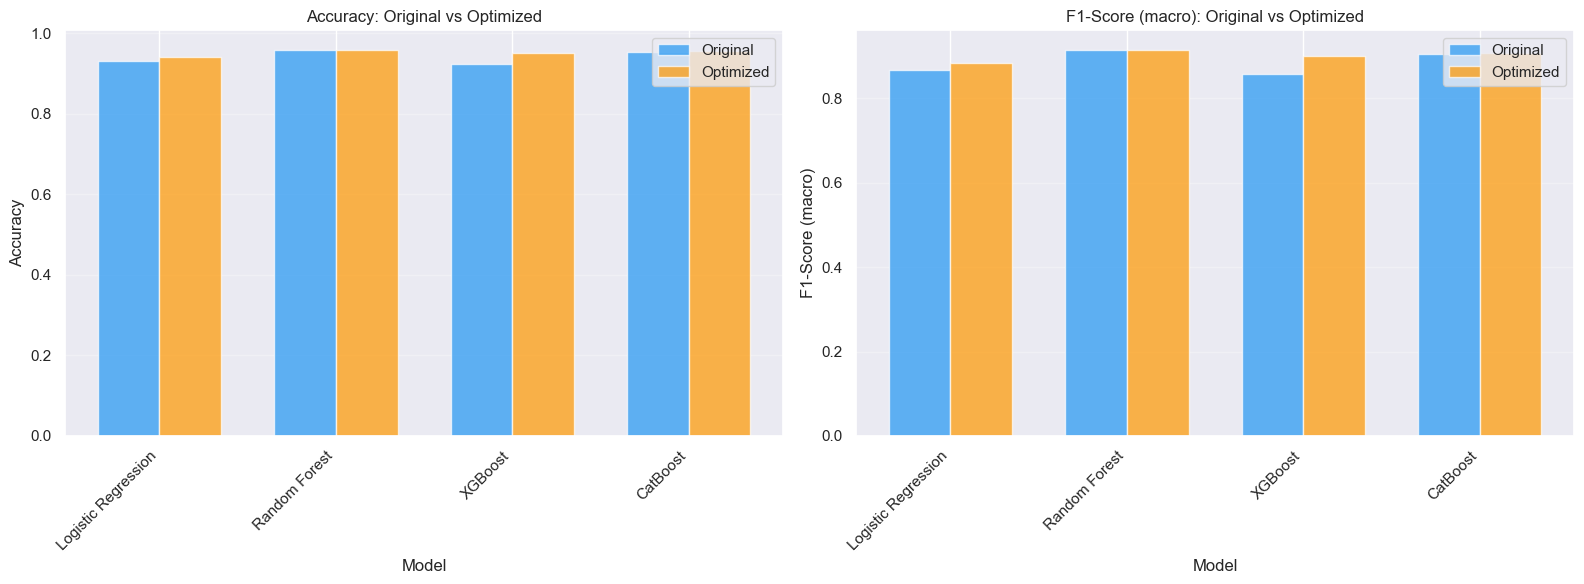


KEY INSIGHTS:
Logistic Regression: Accuracy +0.0110, F1 +0.0155
Random Forest: No improvement (may indicate original params were already good)
XGBoost: Accuracy +0.0270, F1 +0.0431
CatBoost: Accuracy +0.0009, F1 +0.0015


In [ ]:
# Compare optimized models from both approaches
# This provides a fair comparison since both use grid search

print("=" * 70)
print("COMPARISON: OPTIMIZED CLASS WEIGHT vs OPTIMIZED SMOTE")
print("=" * 70)

# Preprocess test data for SMOTE models (same as training preprocessing)
X_test_encoded = preprocess_temp.transform(X_test)

# Convert labels for SMOTE models
int_to_label = {0: "A", 1: "B", 2: "C"}
label_to_int = {"A": 0, "B": 1, "C": 2}
y_test_enc = y_test.map(label_to_int)

comparison_results = {
    "Model": [],
    "Approach": [],
    "Test Accuracy": [],
    "Test F1-Macro": [],
    "Test F1-Weighted": []
}

# Evaluate Class Weight models
print("\n--- CLASS WEIGHT APPROACH (Optimized) ---")
for model_name, model in best_models.items():
    if model_name == "catboost":
        # CatBoost uses raw features and returns numeric labels
        y_pred_enc = model.predict(X_test_cb)
        y_pred_enc = y_pred_enc.ravel() if len(y_pred_enc.shape) > 1 else y_pred_enc
        y_pred = pd.Series(y_pred_enc).map(int_to_label)
    elif model_name == "xgb":
        # XGBoost returns numeric labels (0, 1, 2) - need to convert to strings
        y_pred_enc = model.predict(X_test)
        y_pred_enc = y_pred_enc.ravel() if len(y_pred_enc.shape) > 1 else y_pred_enc
        y_pred = pd.Series(y_pred_enc).map(int_to_label)
    else:
        # Logistic Regression and Random Forest return string labels (A, B, C)
        y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_weighted = f1_score(y_test, y_pred, average="weighted")
    
    comparison_results["Model"].append(model_name.upper())
    comparison_results["Approach"].append("Class Weight")
    comparison_results["Test Accuracy"].append(acc)
    comparison_results["Test F1-Macro"].append(f1_macro)
    comparison_results["Test F1-Weighted"].append(f1_weighted)
    
    print(f"{model_name.upper()}: Accuracy={acc:.4f}, F1-Macro={f1_macro:.4f}, F1-Weighted={f1_weighted:.4f}")

# Evaluate SMOTE models
print("\n--- SMOTE APPROACH (Optimized) ---")
for model_name, model in best_models_smote.items():
    # All SMOTE models use encoded features
    y_pred_enc = model.predict(X_test_encoded)
    y_pred_enc = y_pred_enc.ravel() if len(y_pred_enc.shape) > 1 else y_pred_enc
    y_pred = pd.Series(y_pred_enc).map(int_to_label)
    
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_weighted = f1_score(y_test, y_pred, average="weighted")
    
    comparison_results["Model"].append(model_name.upper())
    comparison_results["Approach"].append("SMOTE")
    comparison_results["Test Accuracy"].append(acc)
    comparison_results["Test F1-Macro"].append(f1_macro)
    comparison_results["Test F1-Weighted"].append(f1_weighted)
    
    print(f"{model_name.upper()}: Accuracy={acc:.4f}, F1-Macro={f1_macro:.4f}, F1-Weighted={f1_weighted:.4f}")

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_results)
print("\n" + "=" * 70)
print("SUMMARY COMPARISON TABLE")
print("=" * 70)
display(comparison_df.round(4))

# Find best model overall
print("=" * 70)
best_overall = comparison_df.loc[comparison_df["Test F1-Macro"].idxmax()]
print(f"\n🏆 BEST MODEL OVERALL:")
print(f"   Model: {best_overall['Model']}")
print(f"   Approach: {best_overall['Approach']}")
print(f"   Test Accuracy: {best_overall['Test Accuracy']:.4f}")
print(f"   Test F1-Macro: {best_overall['Test F1-Macro']:.4f}")
print("=" * 70)

# Evaluate optimized models on test set
print("EVALUATING OPTIMIZED MODELS ON TEST SET")
print("=" * 70)

# Get predictions from optimized models
lr_preds_opt = best_models["lr"].predict(X_test)
rf_preds_opt = best_models["rf"].predict(X_test)
xgb_preds_opt_enc = best_models["xgb"].predict(X_test)
xgb_preds_opt = pd.Series(xgb_preds_opt_enc).map({0: "A", 1: "B", 2: "C"})

# CatBoost optimized model
cb_preds_opt_enc = best_models["catboost"].predict(X_test_cb)
cb_preds_opt_enc = cb_preds_opt_enc.ravel() if len(cb_preds_opt_enc.shape) > 1 else cb_preds_opt_enc
cb_preds_opt = pd.Series(cb_preds_opt_enc).map(int_to_label)

# Calculate metrics for optimized models
optimized_metrics = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "CatBoost"],
    "Accuracy": [
        accuracy_score(y_test, lr_preds_opt),
        accuracy_score(y_test, rf_preds_opt),
        accuracy_score(y_test, xgb_preds_opt),
        accuracy_score(y_test, cb_preds_opt)
    ],
    "F1-Score (macro)": [
        f1_score(y_test, lr_preds_opt, average="macro"),
        f1_score(y_test, rf_preds_opt, average="macro"),
        f1_score(y_test, xgb_preds_opt, average="macro"),
        f1_score(y_test, cb_preds_opt, average="macro")
    ],
    "F1-Score (weighted)": [
        f1_score(y_test, lr_preds_opt, average="weighted"),
        f1_score(y_test, rf_preds_opt, average="weighted"),
        f1_score(y_test, xgb_preds_opt, average="weighted"),
        f1_score(y_test, cb_preds_opt, average="weighted")
    ]
}

optimized_df = pd.DataFrame(optimized_metrics)
print("\nOptimized Models Performance:")
print(optimized_df.round(4))

# Compare with original models
print("\n" + "=" * 70)
print("COMPARISON: ORIGINAL vs OPTIMIZED")
print("=" * 70)

# Get original model predictions (from previous cells)
lr_preds_orig = lr_pipeline.predict(X_test)
rf_preds_orig = pipeline.predict(X_test)
xgb_preds_orig_enc = xgb_pipeline.predict(X_test)
xgb_preds_orig = pd.Series(xgb_preds_orig_enc).map({0: "A", 1: "B", 2: "C"})
cb_preds_orig_enc = catboost_clf.predict(X_test_cb)
cb_preds_orig_enc = cb_preds_orig_enc.ravel() if len(cb_preds_orig_enc.shape) > 1 else cb_preds_orig_enc
cb_preds_orig = pd.Series(cb_preds_orig_enc).map(int_to_label)

comparison_data = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "CatBoost"],
    "Original Accuracy": [
        accuracy_score(y_test, lr_preds_orig),
        accuracy_score(y_test, rf_preds_orig),
        accuracy_score(y_test, xgb_preds_orig),
        accuracy_score(y_test, cb_preds_orig)
    ],
    "Optimized Accuracy": [
        accuracy_score(y_test, lr_preds_opt),
        accuracy_score(y_test, rf_preds_opt),
        accuracy_score(y_test, xgb_preds_opt),
        accuracy_score(y_test, cb_preds_opt)
    ],
    "Original F1 (macro)": [
        f1_score(y_test, lr_preds_orig, average="macro"),
        f1_score(y_test, rf_preds_orig, average="macro"),
        f1_score(y_test, xgb_preds_orig, average="macro"),
        f1_score(y_test, cb_preds_orig, average="macro")
    ],
    "Optimized F1 (macro)": [
        f1_score(y_test, lr_preds_opt, average="macro"),
        f1_score(y_test, rf_preds_opt, average="macro"),
        f1_score(y_test, xgb_preds_opt, average="macro"),
        f1_score(y_test, cb_preds_opt, average="macro")
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df["Accuracy Improvement"] = comparison_df["Optimized Accuracy"] - comparison_df["Original Accuracy"]
comparison_df["F1 Improvement"] = comparison_df["Optimized F1 (macro)"] - comparison_df["Original F1 (macro)"]

print("\n" + comparison_df.round(4).to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
x = np.arange(len(comparison_df))
width = 0.35
axes[0].bar(x - width/2, comparison_df["Original Accuracy"], width, label="Original", color="#2196F3", alpha=0.7)
axes[0].bar(x + width/2, comparison_df["Optimized Accuracy"], width, label="Optimized", color="#FF9800", alpha=0.7)
axes[0].set_xlabel("Model")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy: Original vs Optimized")
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df["Model"], rotation=45, ha="right")
axes[0].legend()
axes[0].grid(axis="y", alpha=0.3)

# F1-score comparison
axes[1].bar(x - width/2, comparison_df["Original F1 (macro)"], width, label="Original", color="#2196F3", alpha=0.7)
axes[1].bar(x + width/2, comparison_df["Optimized F1 (macro)"], width, label="Optimized", color="#FF9800", alpha=0.7)
axes[1].set_xlabel("Model")
axes[1].set_ylabel("F1-Score (macro)")
axes[1].set_title("F1-Score (macro): Original vs Optimized")
axes[1].set_xticks(x)
axes[1].set_xticklabels(comparison_df["Model"], rotation=45, ha="right")
axes[1].legend()
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("KEY INSIGHTS:")
print("=" * 70)
for idx, row in comparison_df.iterrows():
    acc_improvement = row["Accuracy Improvement"]
    f1_improvement = row["F1 Improvement"]
    if acc_improvement > 0 or f1_improvement > 0:
        print(f"{row['Model']}: Accuracy {acc_improvement:+.4f}, F1 {f1_improvement:+.4f}")
    else:
        print(f"{row['Model']}: No improvement (may indicate original params were already good)")

## Feature Importance

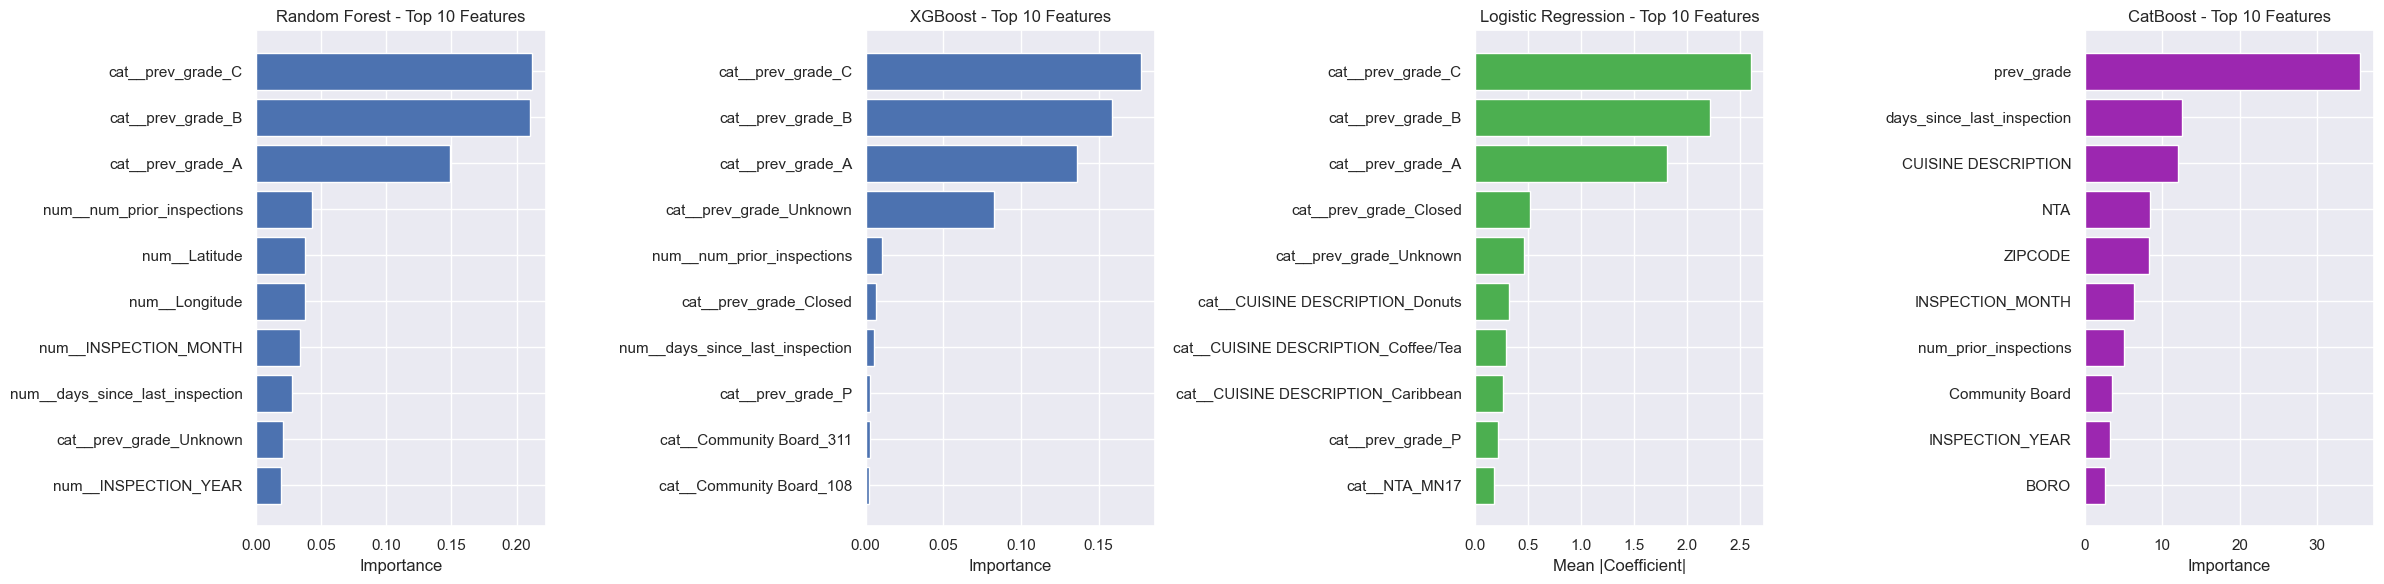

In [44]:
# Feature Importance Comparison
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Get feature names from the preprocessor
feature_names = preprocess.get_feature_names_out()
n_features = len(feature_names)
n_top = min(10, n_features)  # Use all features if we have fewer than 10

# Logistic Regression feature importance (using absolute coefficient values)
# For multinomial logistic regression, use mean absolute coefficients across all classes
lr_coef = lr_pipeline.named_steps["model"].coef_  # Shape: (n_classes, n_features)
lr_importances = np.mean(np.abs(lr_coef), axis=0)  # Average absolute coefficients across classes
lr_top_idx = lr_importances.argsort()[-n_top:][::-1]
axes[2].barh(range(n_top), lr_importances[lr_top_idx][::-1], color="#4CAF50")
axes[2].set_yticks(range(n_top))
axes[2].set_yticklabels([feature_names[i] for i in lr_top_idx][::-1])
axes[2].set_xlabel("Mean |Coefficient|")
axes[2].set_title(f"Logistic Regression - Top {n_top} Features")

# Random Forest feature importance
rf_importances = pipeline.named_steps["model"].feature_importances_
rf_top_idx = rf_importances.argsort()[-n_top:][::-1]
axes[0].barh(range(n_top), rf_importances[rf_top_idx][::-1])
axes[0].set_yticks(range(n_top))
axes[0].set_yticklabels([feature_names[i] for i in rf_top_idx][::-1])
axes[0].set_xlabel("Importance")
axes[0].set_title(f"Random Forest - Top {n_top} Features")

# XGBoost feature importance
xgb_importances = xgb_pipeline.named_steps["model"].feature_importances_
xgb_top_idx = xgb_importances.argsort()[-n_top:][::-1]
axes[1].barh(range(n_top), xgb_importances[xgb_top_idx][::-1])
axes[1].set_yticks(range(n_top))
axes[1].set_yticklabels([feature_names[i] for i in xgb_top_idx][::-1])
axes[1].set_xlabel("Importance")
axes[1].set_title(f"XGBoost - Top {n_top} Features")

# CatBoost feature importance
# Note: CatBoost uses raw features, so we need to map to feature names differently
# CatBoost feature importances correspond to the raw feature order
cb_importances = catboost_clf.feature_importances_
raw_feature_names = list(X_train_cb.columns)
n_cb_features = len(cb_importances)  # CatBoost has different number of features (raw, not preprocessed)
n_top_cb = min(10, n_cb_features)  # Calculate n_top separately for CatBoost

cb_top_idx = cb_importances.argsort()[-n_top_cb:][::-1]
cb_top_feature_names = [raw_feature_names[i] for i in cb_top_idx]

axes[3].barh(range(n_top_cb), cb_importances[cb_top_idx][::-1], color="#9C27B0")
axes[3].set_yticks(range(n_top_cb))
axes[3].set_yticklabels(cb_top_feature_names[::-1])
axes[3].set_xlabel("Importance")
axes[3].set_title(f"CatBoost - Top {n_top_cb} Features")

plt.tight_layout()
plt.show()

## Geographic Distribution

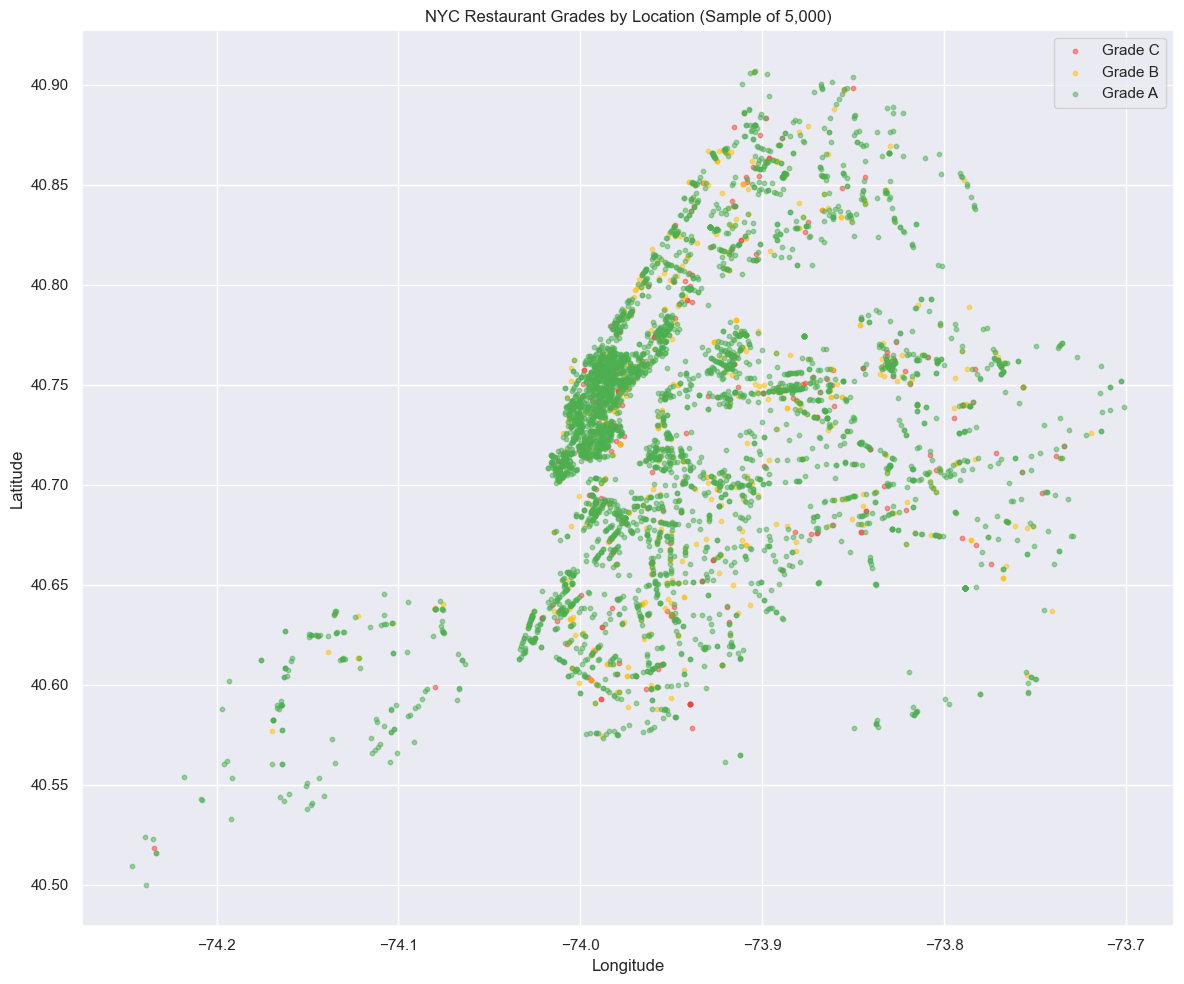

In [45]:
# Geographic Distribution of Grades
fig, ax = plt.subplots(figsize=(12, 10))

# Sample for performance (plotting 80k+ points is slow)
sample_df = df.sample(n=5000, random_state=42)

colors_map = {"A": "#4CAF50", "B": "#FFC107", "C": "#F44336"}
for grade in ["C", "B", "A"]:  # Plot A last so it doesn't cover the others
    subset = sample_df[sample_df["GRADE"] == grade]
    ax.scatter(subset["Longitude"], subset["Latitude"], 
               c=colors_map[grade], label=f"Grade {grade}", alpha=0.5, s=10)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("NYC Restaurant Grades by Location (Sample of 5,000)")
ax.legend()
plt.tight_layout()
plt.show()